# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月  8日 水曜日 07:00:31 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/6/20


4/6/20
Country/Region        
US              366667
Spain           136675
Italy           132547
Germany         103374
France           98963

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 366667
	Confirmed cases on 3/30/20 	 161837
	Ratio: 2.27
	Weekly increase: 126.6 %
	Daily increase: 12.4 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9994454223734401
	Doubling Time (during middle of growth):  6.06 (± 0.17 ) days
	param:  [ 1.28731147e+07  2.28856145e-01 -6.49041148e+02  5.28504381e+05]

** Based on Exponential Fit **

	R^2: 0.9892140421584288
	Doubling Time (represents overall growth):  4.87 (± 0.24 ) days
	param:  [   9.24217038    0.14232132 -100.        ]


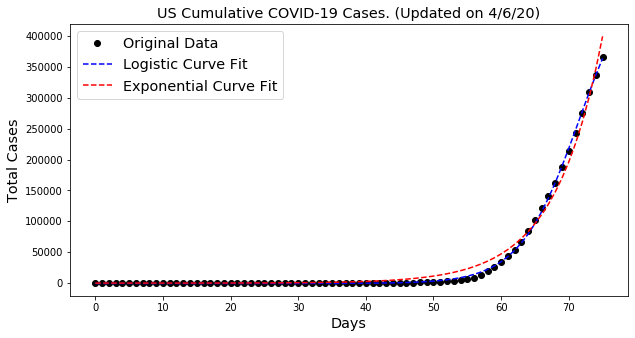



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 136675
	Confirmed cases on 3/30/20 	 87956
	Ratio: 1.55
	Weekly increase: 55.4 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9996918955393973
	Doubling Time (during middle of growth):  6.57 (± 0.14 ) days
	param:  [ 1.66962652e+05  2.11077506e-01 -2.89937427e+02  1.60948643e+05]

** Based on Exponential Fit **

	R^2: 0.9721905191910898
	Doubling Time (represents overall growth):  6.09 (± 0.55 ) days
	param:  [ 100.            0.11378279 -100.        ]


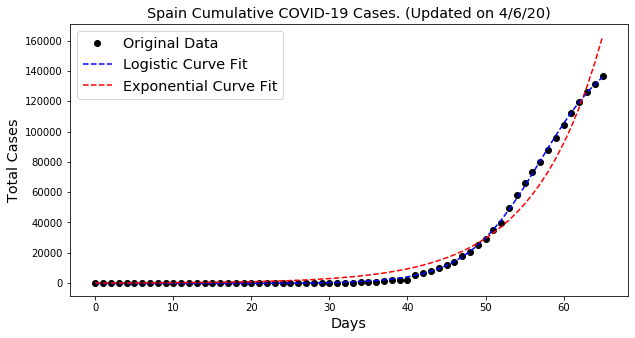



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 132547
	Confirmed cases on 3/30/20 	 101739
	Ratio: 1.3
	Weekly increase: 30.3 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.3 days

** Based on Logistic Fit**

	R^2: 0.9994088603939184
	Doubling Time (during middle of growth):  8.38 (± 0.24 ) days
	param:  [ 7.21328704e+03  1.65441424e-01 -6.38747570e+02  1.46576571e+05]

 exponential R^2  0.8929019189560969


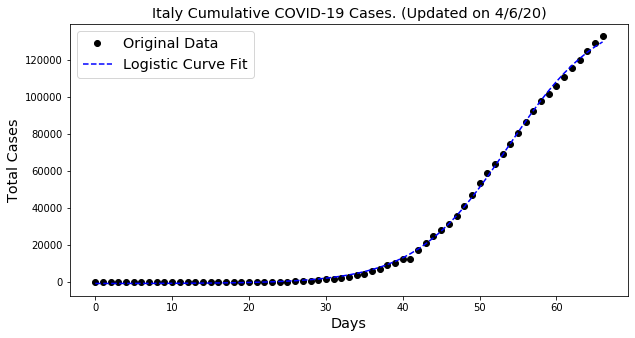



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 103374
	Confirmed cases on 3/30/20 	 66885
	Ratio: 1.55
	Weekly increase: 54.6 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9992820501148689
	Doubling Time (during middle of growth):  6.98 (± 0.22 ) days
	param:  [ 2.25538068e+05  1.98685540e-01 -2.75553918e+02  1.24384598e+05]

** Based on Exponential Fit **

	R^2: 0.9769897220607827
	Doubling Time (represents overall growth):  6.84 (± 0.55 ) days
	param:  [  98.67563201    0.10135325 -100.        ]


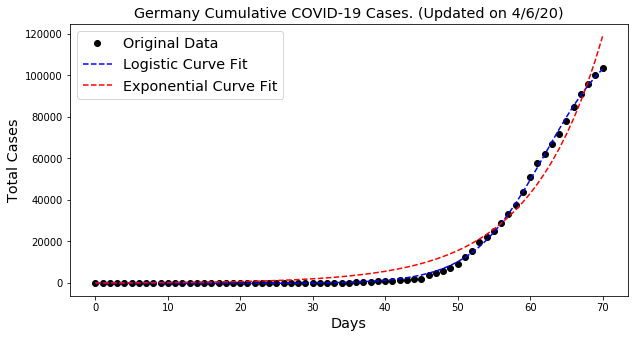



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 98963
	Confirmed cases on 3/30/20 	 45170
	Ratio: 2.19
	Weekly increase: 119.1 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9943129668077705
	Doubling Time (during middle of growth):  9.97 (± 1.06 ) days
	param:  [ 6.50023826e+04  1.39062681e-01 -4.06627553e+02  3.57675114e+05]

** Based on Exponential Fit **

	R^2: 0.9930199431678067
	Doubling Time (represents overall growth):  5.72 (± 0.24 ) days
	param:  [  14.94719475    0.12122677 -100.        ]


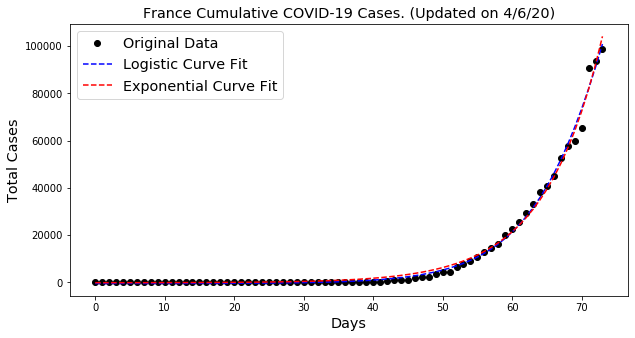



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 82665
	Confirmed cases on 3/30/20 	 82198
	Ratio: 1.01
	Weekly increase: 0.6 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 856.4 days

** Based on Logistic Fit**

	R^2: 0.9958335805681464
	Doubling Time (during middle of growth):  6.58 (± 0.46 ) days
	param:  [ 4.05764418e+01  2.10618522e-01 -1.61070160e+03  8.14895025e+04]

 exponential R^2  -2.3722543276819628


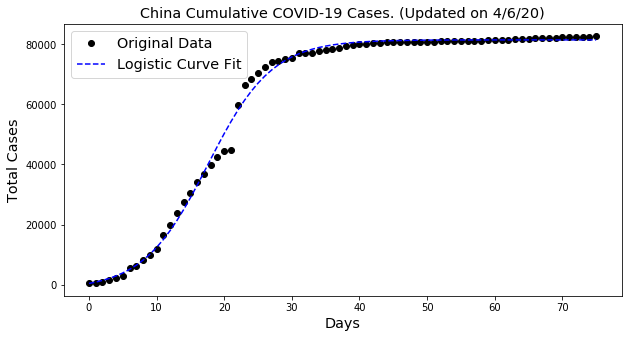



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 60500
	Confirmed cases on 3/30/20 	 41495
	Ratio: 1.46
	Weekly increase: 45.8 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.997431991609513
	Doubling Time (during middle of growth):  17.43 (± 2.66 ) days
	param:  [ 7.74471420e+01  7.95476132e-02 -3.43932296e+03  1.82598762e+05]

 exponential R^2  0.7843735490976448


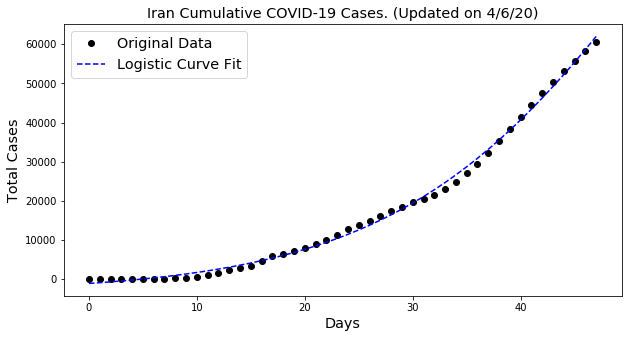



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 52279
	Confirmed cases on 3/30/20 	 22453
	Ratio: 2.33
	Weekly increase: 132.8 %
	Daily increase: 12.8 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9996373565485516
	Doubling Time (during middle of growth):  7.02 (± 0.18 ) days
	param:  [ 3.56710545e+05  1.97391414e-01 -6.34871613e+01  9.34194085e+04]

** Based on Exponential Fit **

	R^2: 0.9944223078269988
	Doubling Time (represents overall growth):  5.01 (± 0.19 ) days
	param:  [   6.03270685    0.13842453 -100.        ]


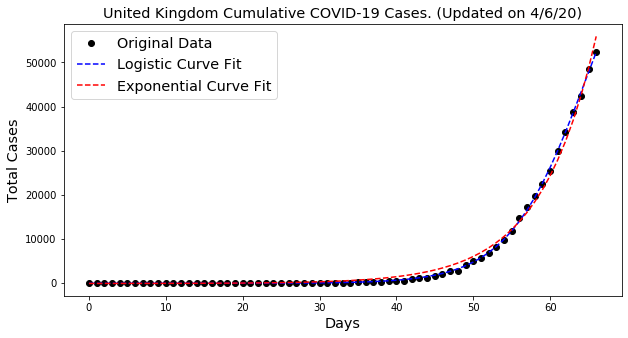



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 30217
	Confirmed cases on 3/30/20 	 10827
	Ratio: 2.79
	Weekly increase: 179.1 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9985837515253162
	Doubling Time (during middle of growth):  5.16 (± 0.46 ) days
	param:  [ 4.85922290e+02  2.68798462e-01 -3.97774001e+02  4.32529515e+04]

 exponential R^2  0.9468440317258154


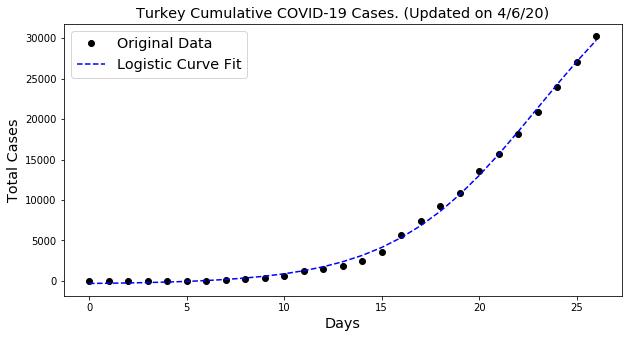



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 21657
	Confirmed cases on 3/30/20 	 15922
	Ratio: 1.36
	Weekly increase: 36.0 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.8 days

** Based on Logistic Fit**

	R^2: 0.9983669797871169
	Doubling Time (during middle of growth):  6.79 (± 0.43 ) days
	param:  [ 4.47305735e+02  2.04034224e-01 -2.49798976e+02  2.34740839e+04]

 exponential R^2  0.8465178045045195


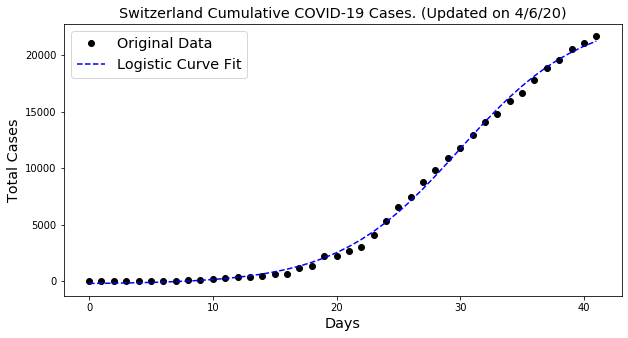



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 20814
	Confirmed cases on 3/30/20 	 11899
	Ratio: 1.75
	Weekly increase: 74.9 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9989959109112314
	Doubling Time (during middle of growth):  6.56 (± 0.27 ) days
	param:  [ 1.54252506e+05  2.11422144e-01 -9.07700711e+00  2.71466135e+04]

** Based on Exponential Fit **

	R^2: 0.9852456467891585
	Doubling Time (represents overall growth):  5.9 (± 0.4 ) days
	param:  [  15.9561526     0.11745531 -100.        ]


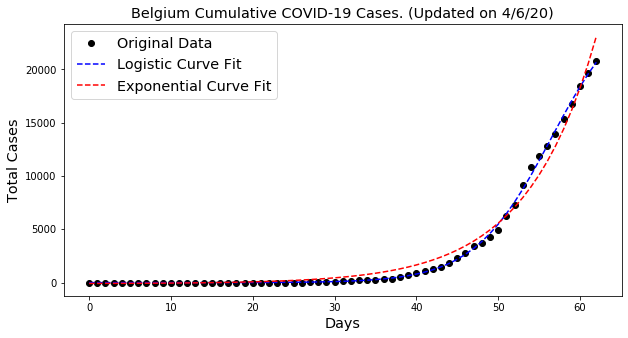



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 18926
	Confirmed cases on 3/30/20 	 11817
	Ratio: 1.6
	Weekly increase: 60.2 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.3 days

** Based on Logistic Fit**

	R^2: 0.999535545607493
	Doubling Time (during middle of growth):  7.4 (± 0.28 ) days
	param:  [ 4.05245989e+02  1.87249320e-01 -1.37183417e+02  2.37325830e+04]

 exponential R^2  0.9334974543859522


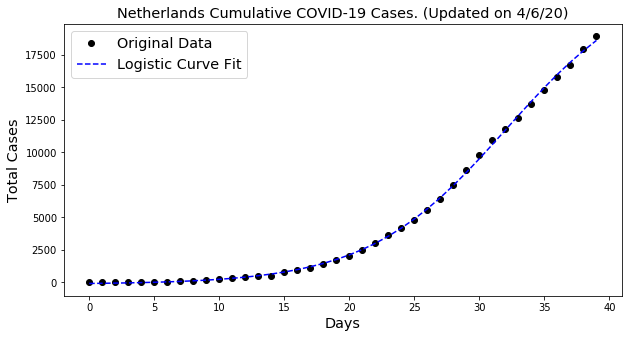



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 16563
	Confirmed cases on 3/30/20 	 7398
	Ratio: 2.24
	Weekly increase: 123.9 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9984709104016133
	Doubling Time (during middle of growth):  6.53 (± 0.32 ) days
	param:  [ 1.97461610e+06  2.12220151e-01 -2.11027957e+01  2.57955190e+04]

** Based on Exponential Fit **

	R^2: 0.9913590801648178
	Doubling Time (represents overall growth):  5.07 (± 0.23 ) days
	param:  [   1.09168068    0.1367296  -100.        ]


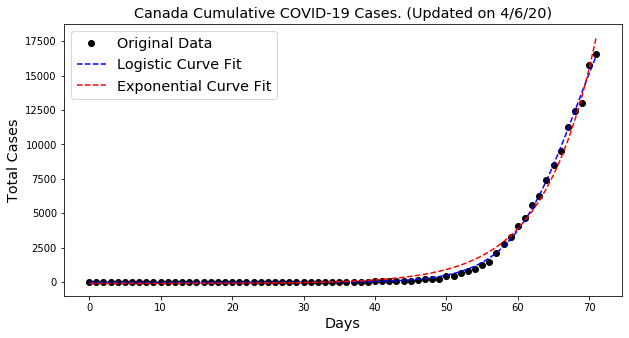



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 12297
	Confirmed cases on 3/30/20 	 9618
	Ratio: 1.28
	Weekly increase: 27.9 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9995778674048722
	Doubling Time (during middle of growth):  5.54 (± 0.17 ) days
	param:  [ 1.70356013e+03  2.50317138e-01 -2.98399635e+01  1.29584381e+04]

 exponential R^2  0.8943456186068418


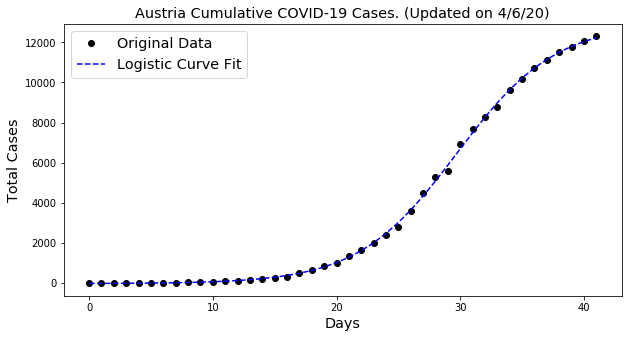



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 12161
	Confirmed cases on 3/30/20 	 4579
	Ratio: 2.66
	Weekly increase: 165.6 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9971953073194988
	Doubling Time (during middle of growth):  7.53 (± 0.78 ) days
	param:  [ 1.66629190e+03  1.84103109e-01 -9.75442378e+01  2.54520402e+04]

** Based on Exponential Fit **

	R^2: 0.9927575657407328
	Doubling Time (represents overall growth):  5.04 (± 0.32 ) days
	param:  [  53.79779359    0.13741207 -100.        ]


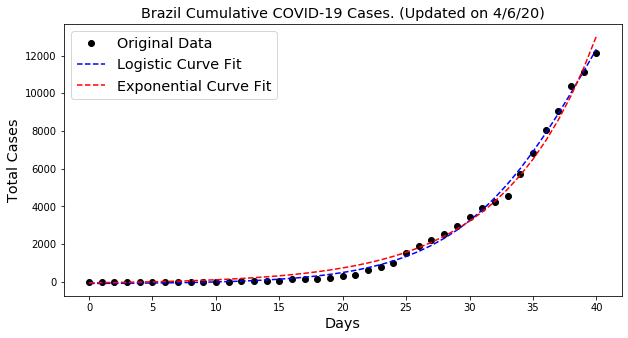



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 11730
	Confirmed cases on 3/30/20 	 6408
	Ratio: 1.83
	Weekly increase: 83.1 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9996076203769441
	Doubling Time (during middle of growth):  5.87 (± 0.21 ) days
	param:  [ 8.59281702e+02  2.36306202e-01 -7.07915790e+01  1.43134597e+04]

** Based on Exponential Fit **

	R^2: 0.9624745776860082
	Doubling Time (represents overall growth):  4.91 (± 0.8 ) days
	param:  [100.           0.14107508  64.05148745]


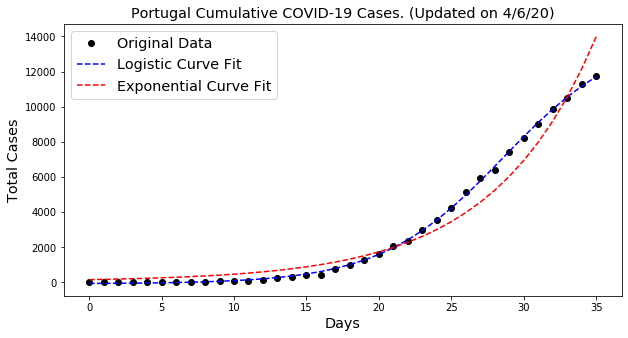



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 10284
	Confirmed cases on 3/30/20 	 9661
	Ratio: 1.06
	Weekly increase: 6.4 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 77.6 days

** Based on Logistic Fit**

	R^2: 0.9920395216240924
	Doubling Time (during middle of growth):  5.97 (± 0.6 ) days
	param:  [ 1.38348483e+04  2.32217749e-01 -1.12497241e+02  9.35980819e+03]

 exponential R^2  0.6195074327524333


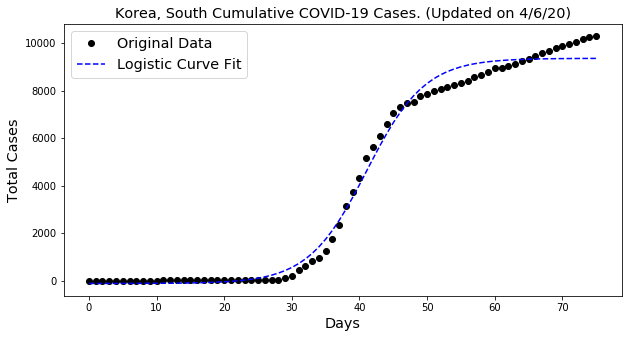



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 8904
	Confirmed cases on 3/30/20 	 4695
	Ratio: 1.9
	Weekly increase: 89.6 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9983809386192433
	Doubling Time (during middle of growth):  5.32 (± 0.32 ) days
	param:  [ 2.35074560e+04  2.60784125e-01 -3.31037494e+00  1.04648644e+04]

** Based on Exponential Fit **

	R^2: 0.9763213850689262
	Doubling Time (represents overall growth):  5.56 (± 0.6 ) days
	param:  [  37.20714877    0.12467554 -100.        ]


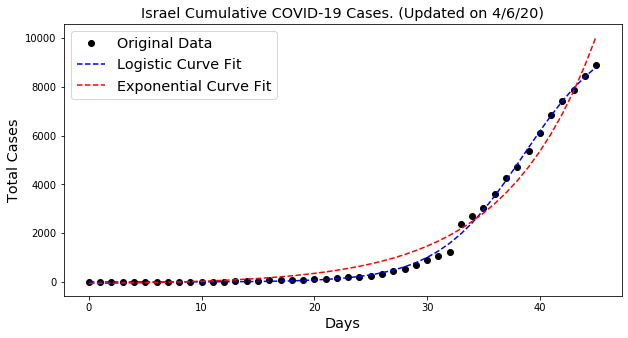



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 7206
	Confirmed cases on 3/30/20 	 4028
	Ratio: 1.79
	Weekly increase: 78.9 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9975304901682778
	Doubling Time (during middle of growth):  11.74 (± 0.88 ) days
	param:  [ 3.29738671e+03  1.18128793e-01 -6.18573345e+01  1.73621524e+04]

** Based on Exponential Fit **

	R^2: 0.9951227526951729
	Doubling Time (represents overall growth):  7.58 (± 0.29 ) days
	param:  [ 1.86690558e+01  9.14153216e-02 -1.00000000e+02]


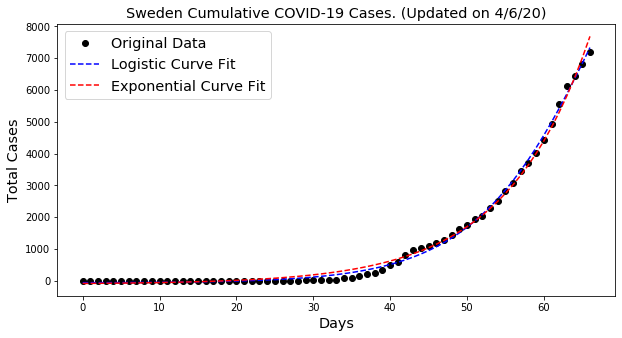



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 6343
	Confirmed cases on 3/30/20 	 1836
	Ratio: 3.45
	Weekly increase: 245.5 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.996843838155697
	Doubling Time (represents overall growth):  3.94 (± 0.11 ) days
	param:  [  0.05893467   0.17614552 -24.21240301]


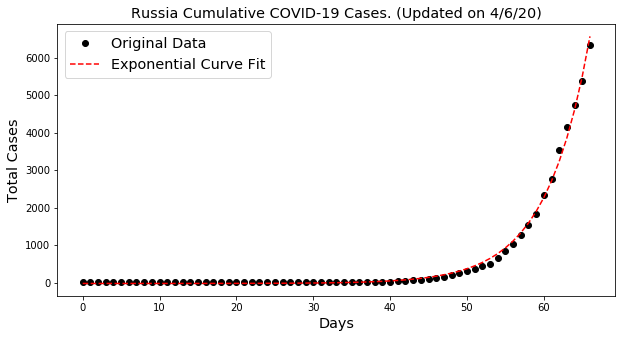



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 5865
	Confirmed cases on 3/30/20 	 4445
	Ratio: 1.32
	Weekly increase: 31.9 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.5 days

** Based on Logistic Fit**

	R^2: 0.9982434277405503
	Doubling Time (during middle of growth):  10.11 (± 0.85 ) days
	param:  [ 5.69451494e+01  1.37164092e-01 -2.27685039e+02  7.31817795e+03]

 exponential R^2  0.896161884247719


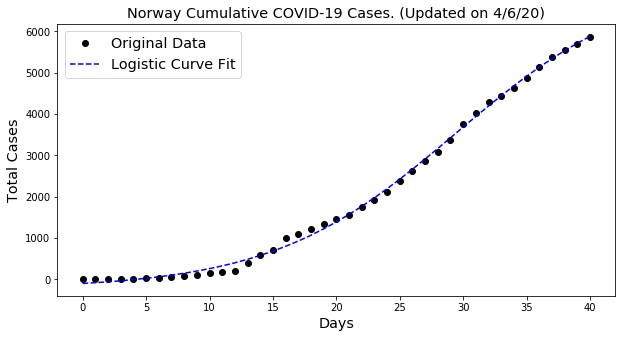



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 5797
	Confirmed cases on 3/30/20 	 4361
	Ratio: 1.33
	Weekly increase: 32.9 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 17.0 days

** Based on Logistic Fit**

	R^2: 0.9996569198690481
	Doubling Time (during middle of growth):  5.31 (± 0.11 ) days
	param:  [7.68246675e+06 2.60869293e-01 1.56439866e+01 6.16715259e+03]

** Based on Exponential Fit **

	R^2: 0.962507698065885
	Doubling Time (represents overall growth):  7.32 (± 0.75 ) days
	param:  [ 8.43265305e+00  9.47265904e-02 -1.00000000e+02]


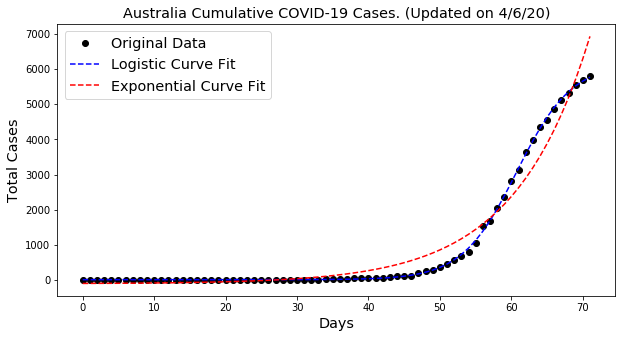



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 5364
	Confirmed cases on 3/30/20 	 2910
	Ratio: 1.84
	Weekly increase: 84.3 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9981709938479691
	Doubling Time (during middle of growth):  7.64 (± 0.64 ) days
	param:  [ 3.57146068e+02  1.81394174e-01 -8.54009524e+01  7.58406473e+03]

** Based on Exponential Fit **

	R^2: 0.9852337417354425
	Doubling Time (represents overall growth):  6.27 (± 0.67 ) days
	param:  [  98.96561751    0.11052653 -100.        ]


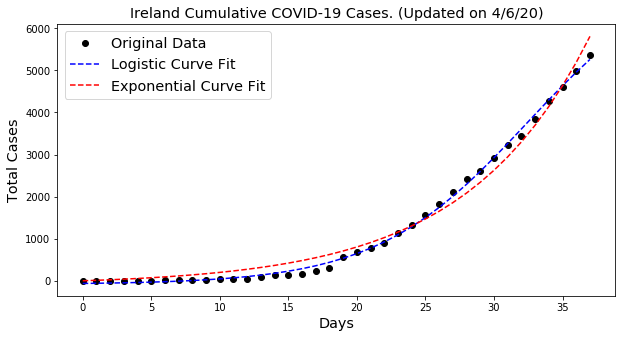



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4875
	Confirmed cases on 3/30/20 	 2755
	Ratio: 1.77
	Weekly increase: 77.0 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.994225251839968
	Doubling Time (during middle of growth):  21.21 (± 2.63 ) days
	param:  [ 1.51184924e+08  6.53628734e-02 -5.42164732e+02  6.36627285e+10]

** Based on Exponential Fit **

	R^2: 0.9732768173154418
	Doubling Time (represents overall growth):  6.85 (± 0.97 ) days
	param:  [100.           0.10125352 100.        ]


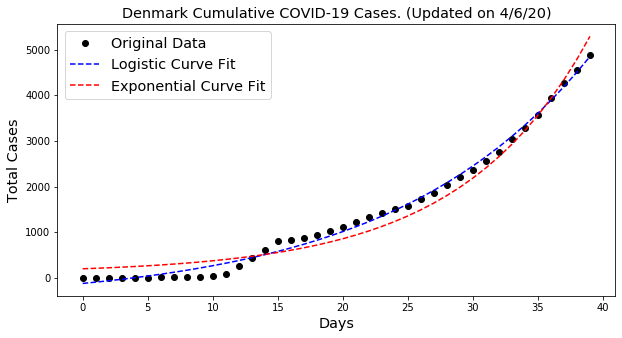



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4822
	Confirmed cases on 3/30/20 	 3001
	Ratio: 1.61
	Weekly increase: 60.7 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.9988177999128145
	Doubling Time (during middle of growth):  7.31 (± 0.48 ) days
	param:  [ 2.31208165e+02  1.89635050e-01 -6.69471567e+01  6.00719202e+03]

** Based on Exponential Fit **

	R^2: 0.9674441276644915
	Doubling Time (represents overall growth):  6.18 (± 1.0 ) days
	param:  [100.           0.11220702 -36.35666527]


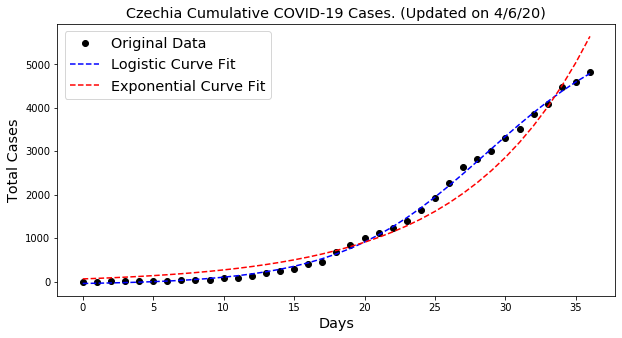



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4815
	Confirmed cases on 3/30/20 	 2449
	Ratio: 1.97
	Weekly increase: 96.6 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9993681721586009
	Doubling Time (during middle of growth):  6.86 (± 0.35 ) days
	param:  [ 4.23365325e+02  2.02213616e-01 -5.49768237e+01  6.88587476e+03]

** Based on Exponential Fit **

	R^2: 0.9876297589583645
	Doubling Time (represents overall growth):  5.74 (± 0.59 ) days
	param:  [  87.87800118    0.12077546 -100.        ]


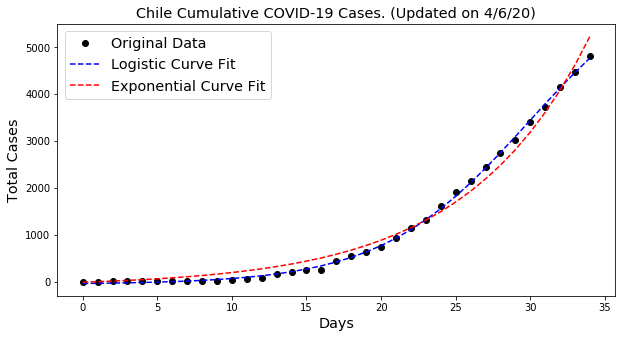



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4778
	Confirmed cases on 3/30/20 	 1251
	Ratio: 3.82
	Weekly increase: 281.9 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.994369806218973
	Doubling Time (represents overall growth):  3.99 (± 0.15 ) days
	param:  [0.03942063 0.17390018 7.8245273 ]


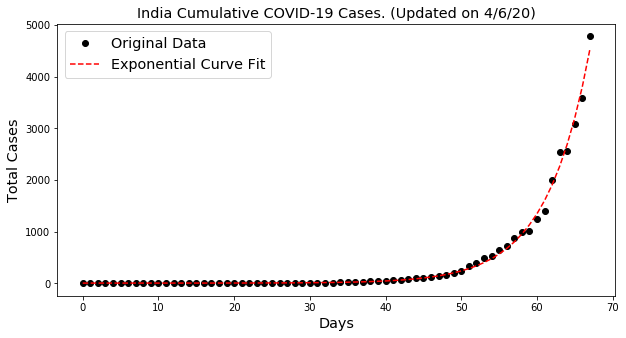



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4413
	Confirmed cases on 3/30/20 	 2055
	Ratio: 2.15
	Weekly increase: 114.7 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9992582042734044
	Doubling Time (during middle of growth):  8.65 (± 0.6 ) days
	param:  [ 2.20696286e+02  1.60209892e-01 -8.48374503e+01  9.45569808e+03]

** Based on Exponential Fit **

	R^2: 0.9951850678160403
	Doubling Time (represents overall growth):  5.79 (± 0.38 ) days
	param:  [  91.42753746    0.11978231 -100.        ]


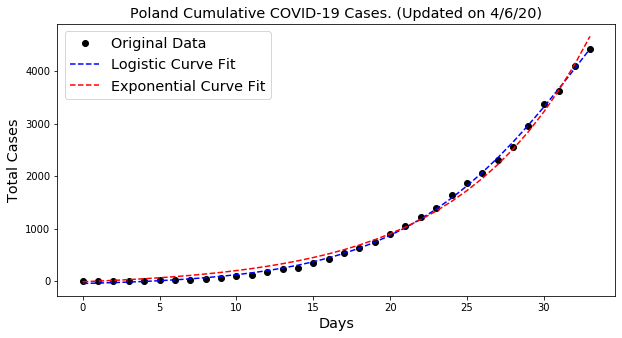



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 4057
	Confirmed cases on 3/30/20 	 2109
	Ratio: 1.92
	Weekly increase: 92.4 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9983878457386601
	Doubling Time (during middle of growth):  6.72 (± 0.48 ) days
	param:  [ 1.86421799e+03  2.06142039e-01 -1.09976919e+01  6.10769789e+03]

** Based on Exponential Fit **

	R^2: 0.9904530725154752
	Doubling Time (represents overall growth):  5.69 (± 0.43 ) days
	param:  [  34.65421808    0.12183744 -100.        ]


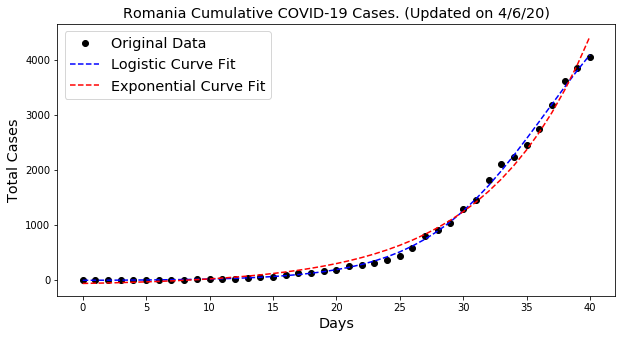



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3793
	Confirmed cases on 3/30/20 	 2626
	Ratio: 1.44
	Weekly increase: 44.4 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.9977151346110241
	Doubling Time (during middle of growth):  7.91 (± 0.44 ) days
	param:  [ 5.31994941e+04  1.75314158e-01 -4.28255339e+00  4.32345530e+03]

** Based on Exponential Fit **

	R^2: 0.9773716715240228
	Doubling Time (represents overall growth):  8.62 (± 0.7 ) days
	param:  [ 1.33158231e+01  8.04051643e-02 -1.00000000e+02]


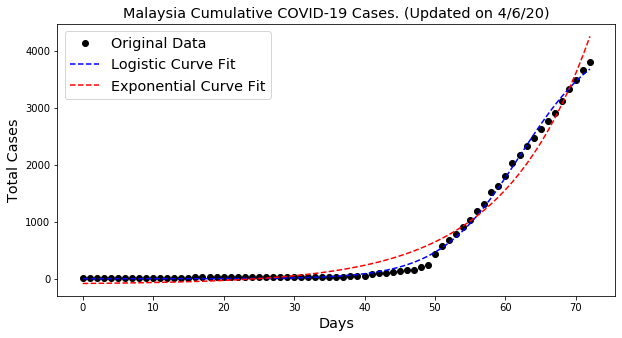



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3766
	Confirmed cases on 3/30/20 	 1717
	Ratio: 2.19
	Weekly increase: 119.3 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9923650543515775
	Doubling Time (during middle of growth):  11.01 (± 2.39 ) days
	param:  [ 2.92265612e+02  1.25958804e-01 -1.14146313e+02  1.04823806e+04]

** Based on Exponential Fit **

	R^2: 0.990159502111979
	Doubling Time (represents overall growth):  6.55 (± 0.53 ) days
	param:  [  55.13966524    0.10579947 -100.        ]


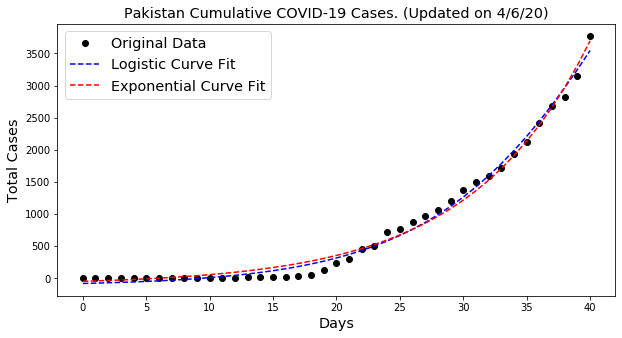



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3747
	Confirmed cases on 3/30/20 	 1962
	Ratio: 1.91
	Weekly increase: 91.0 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9922977134986173
	Doubling Time (during middle of growth):  6.62 (± 1.06 ) days
	param:  [ 4.79783170e+02  2.09494128e-01 -6.15283689e+01  4.79457432e+03]

** Based on Exponential Fit **

	R^2: 0.9705312025089439
	Doubling Time (represents overall growth):  6.36 (± 1.01 ) days
	param:  [  86.95603256    0.10906667 -100.        ]


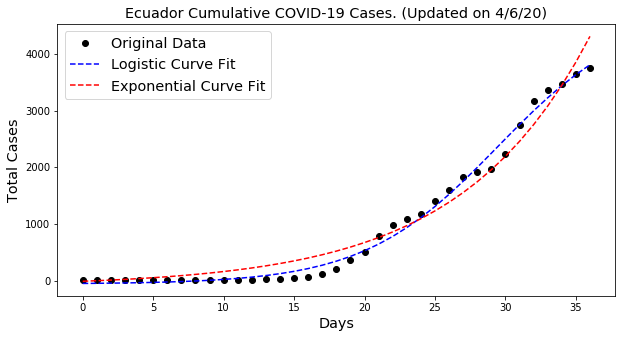



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3660
	Confirmed cases on 3/30/20 	 1546
	Ratio: 2.37
	Weekly increase: 136.7 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.996744383456212
	Doubling Time (during middle of growth):  5.39 (± 0.39 ) days
	param:  [9.18553719e+06 2.57175554e-01 1.36979949e+01 4.71926667e+03]

** Based on Exponential Fit **

	R^2: 0.9845117999712513
	Doubling Time (represents overall growth):  5.12 (± 0.33 ) days
	param:  [  0.46360731   0.13539343 -34.72133943]


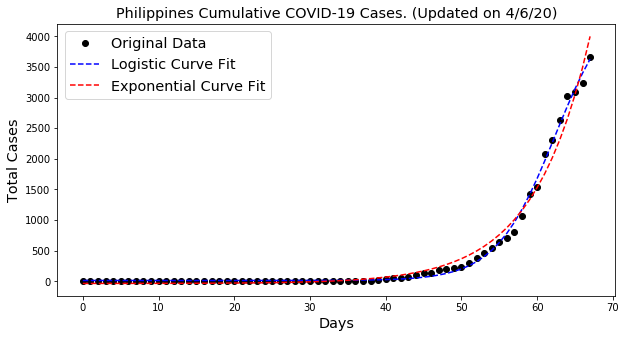



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 3654
	Confirmed cases on 3/30/20 	 1866
	Ratio: 1.96
	Weekly increase: 95.8 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9909934734248337
	Doubling Time (during middle of growth):  18.94 (± 0.97 ) days
	param:  [9.67175660e+09 7.31832488e-02 1.53468362e+00 1.34616481e+11]

** Based on Exponential Fit **

	R^2: 0.9909934736970816
	Doubling Time (represents overall growth):  9.47 (± 0.48 ) days
	param:  [13.91856088  0.0731832   1.5341576 ]


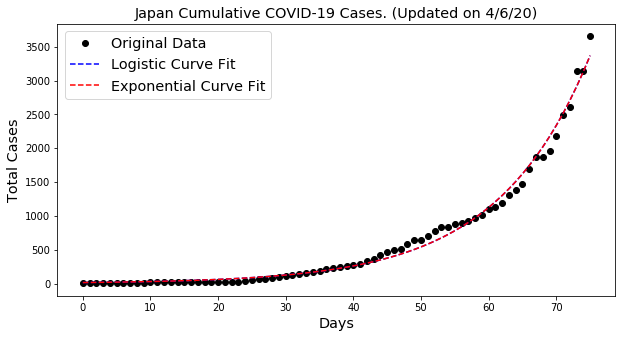



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2843
	Confirmed cases on 3/30/20 	 1988
	Ratio: 1.43
	Weekly increase: 43.0 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.9970332636575827
	Doubling Time (during middle of growth):  5.6 (± 0.49 ) days
	param:  [ 6.76353381e+02  2.47346657e-01 -4.49484887e+01  3.00101645e+03]

 exponential R^2  0.9469844179672876


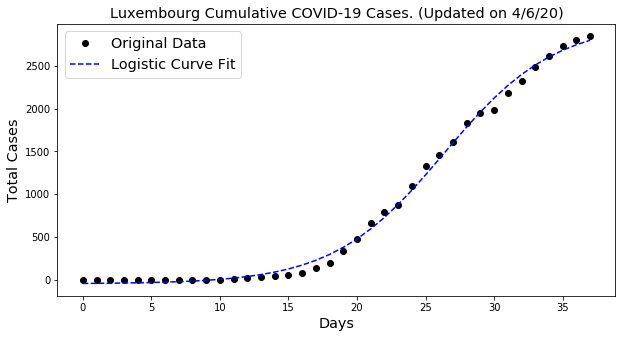



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2605
	Confirmed cases on 3/30/20 	 1453
	Ratio: 1.79
	Weekly increase: 79.3 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9967218515866245
	Doubling Time (during middle of growth):  8.32 (± 1.04 ) days
	param:  [ 1.55809959e+02  1.66716358e-01 -6.19734631e+01  3.69187736e+03]

** Based on Exponential Fit **

	R^2: 0.9860859940316647
	Doubling Time (represents overall growth):  6.96 (± 0.81 ) days
	param:  [ 8.77758175e+01  9.95780982e-02 -1.00000000e+02]


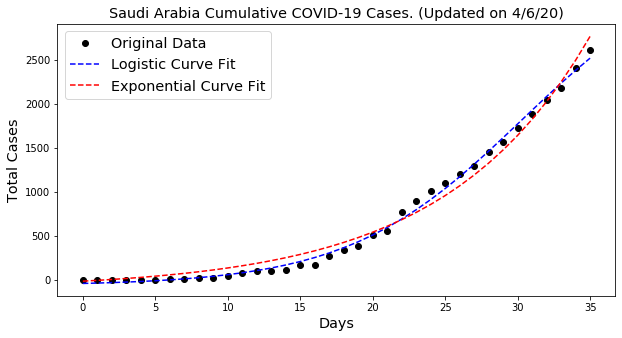



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2561
	Confirmed cases on 3/30/20 	 950
	Ratio: 2.7
	Weekly increase: 169.6 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9951695011957336
	Doubling Time (during middle of growth):  10.45 (± nan ) days
	param:  [ 6.25827992e+08  1.32640615e-01 -5.01097758e+01  2.61254195e+10]

** Based on Exponential Fit **

	R^2: 0.995169501655381
	Doubling Time (represents overall growth):  5.23 (± 0.34 ) days
	param:  [ 41.74531235   0.13264066 -50.10959393]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



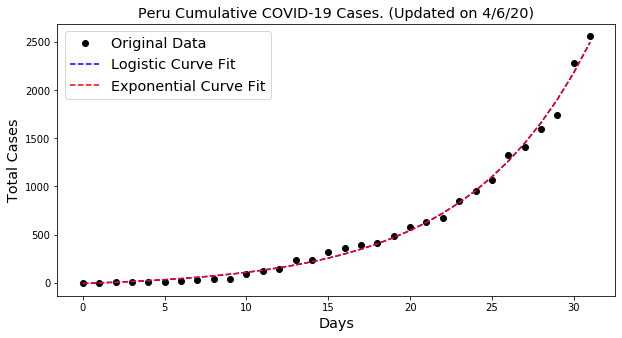



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2491
	Confirmed cases on 3/30/20 	 1414
	Ratio: 1.76
	Weekly increase: 76.2 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9987160266500847
	Doubling Time (during middle of growth):  8.5 (± 0.67 ) days
	param:  [ 1.44801198e+02  1.63014090e-01 -5.79969992e+01  3.60774028e+03]

** Based on Exponential Fit **

	R^2: 0.9887808947149078
	Doubling Time (represents overall growth):  7.07 (± 0.74 ) days
	param:  [ 8.88004018e+01  9.79847160e-02 -1.00000000e+02]


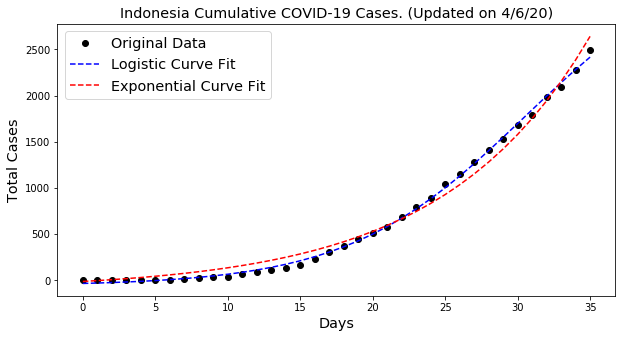



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2220
	Confirmed cases on 3/30/20 	 1524
	Ratio: 1.46
	Weekly increase: 45.7 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.9983181088173058
	Doubling Time (during middle of growth):  5.99 (± 0.28 ) days
	param:  [3.94560187e+06 2.31469723e-01 2.28280377e+01 2.43536537e+03]

** Based on Exponential Fit **

	R^2: 0.9708257486356496
	Doubling Time (represents overall growth):  7.3 (± 0.63 ) days
	param:  [  2.10588834   0.09489699 -27.30938153]


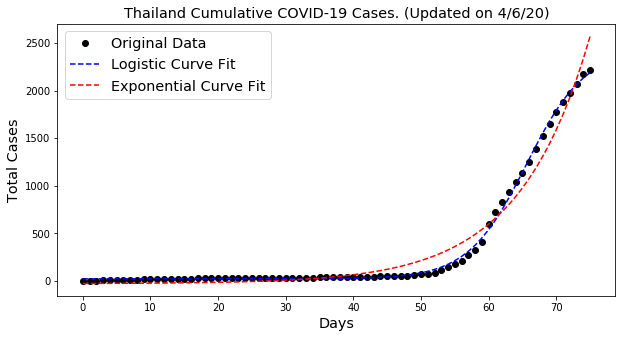



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2200
	Confirmed cases on 3/30/20 	 785
	Ratio: 2.8
	Weekly increase: 180.3 %
	Daily increase: 15.9 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9979612510801585
	Doubling Time (during middle of growth):  9.18 (± 1.32 ) days
	param:  [ 1.02874242e+03  1.50971312e-01 -3.75723064e+01  2.34585276e+04]

** Based on Exponential Fit **

	R^2: 0.9979073404193387
	Doubling Time (represents overall growth):  4.88 (± 0.2 ) days
	param:  [ 27.59200404   0.14197947 -47.42420073]


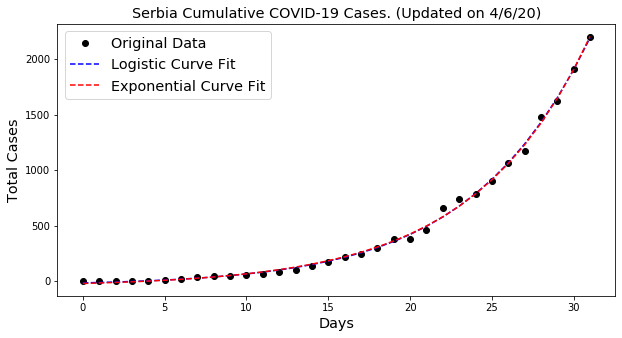



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2176
	Confirmed cases on 3/30/20 	 1352
	Ratio: 1.61
	Weekly increase: 60.9 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.9949837827358157
	Doubling Time (during middle of growth):  9.05 (± 0.81 ) days
	param:  [ 1.20400577e+04  1.53236006e-01 -1.47680414e+01  2.74630350e+03]

** Based on Exponential Fit **

	R^2: 0.9845839173155215
	Doubling Time (represents overall growth):  8.12 (± 0.55 ) days
	param:  [  6.95550284   0.08533845 -59.56228203]


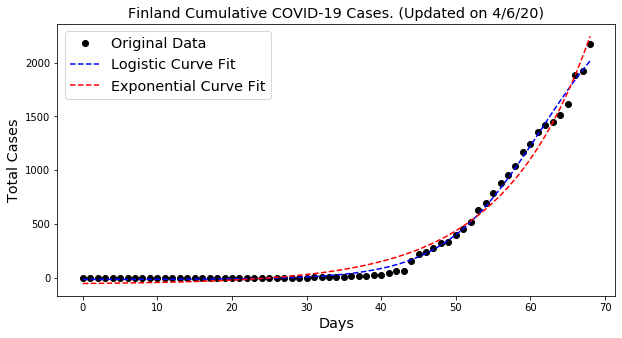



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2143
	Confirmed cases on 3/30/20 	 993
	Ratio: 2.16
	Weekly increase: 115.8 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.998588871836205
	Doubling Time (during middle of growth):  7.37 (± 0.55 ) days
	param:  [ 1.00057617e+03  1.88068970e-01 -1.69439644e+01  3.73906925e+03]

** Based on Exponential Fit **

	R^2: 0.9945519828525212
	Doubling Time (represents overall growth):  5.64 (± 0.33 ) days
	param:  [ 21.3161134    0.12286134 -70.10856508]


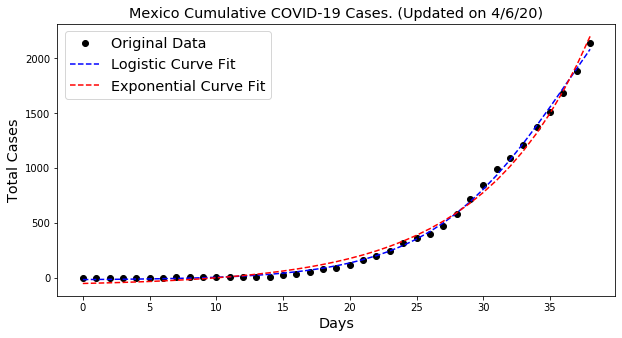



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 2076
	Confirmed cases on 3/30/20 	 611
	Ratio: 3.4
	Weekly increase: 239.8 %
	Daily increase: 19.1 % per day
	Doubling Time (represents recent growth): 4.0 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9970498931338337
	Doubling Time (represents overall growth):  4.02 (± 0.11 ) days
	param:  [1.65589095e-02 1.72553206e-01 1.80995460e+01]


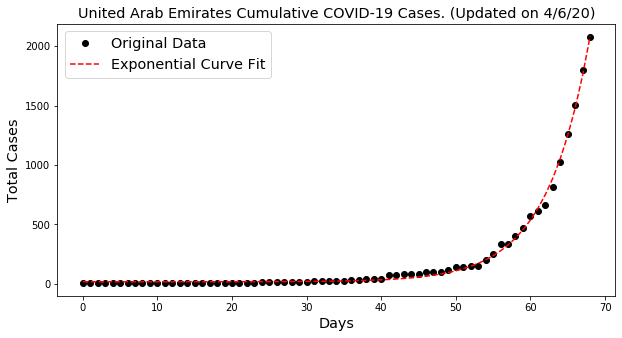



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1988
	Confirmed cases on 3/30/20 	 989
	Ratio: 2.01
	Weekly increase: 101.0 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9968670542946945
	Doubling Time (during middle of growth):  7.9 (± 1.32 ) days
	param:  [ 7.13484361e+01  1.75467322e-01 -6.49134372e+01  3.20195824e+03]

** Based on Exponential Fit **

	R^2: 0.9886847449438786
	Doubling Time (represents overall growth):  6.04 (± 0.77 ) days
	param:  [ 100.            0.11471701 -100.        ]


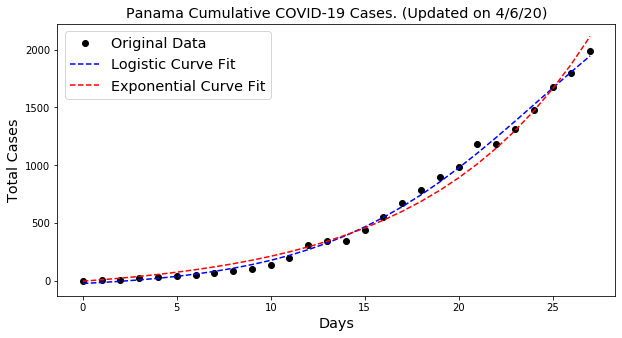



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1832
	Confirmed cases on 3/30/20 	 693
	Ratio: 2.64
	Weekly increase: 164.4 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

 logistic R^2  0.9215430318720723

 exponential R^2  0.9215430353022489


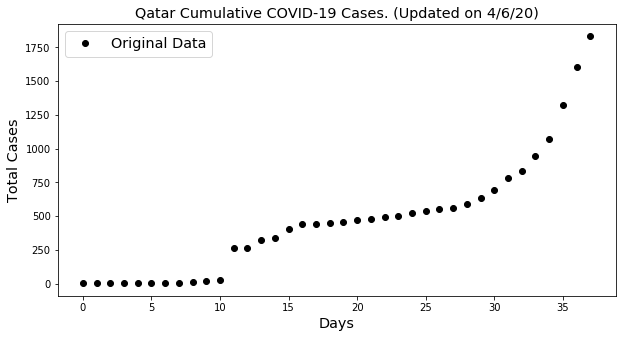



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1828
	Confirmed cases on 3/30/20 	 901
	Ratio: 2.03
	Weekly increase: 102.9 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9971774847842261
	Doubling Time (during middle of growth):  5.21 (± 0.47 ) days
	param:  [ 2.63766464e+03  2.66283252e-01 -1.26638018e+01  2.10636955e+03]

** Based on Exponential Fit **

	R^2: 0.9773803660457626
	Doubling Time (represents overall growth):  6.03 (± 0.79 ) days
	param:  [  33.70959246    0.1149764  -100.        ]


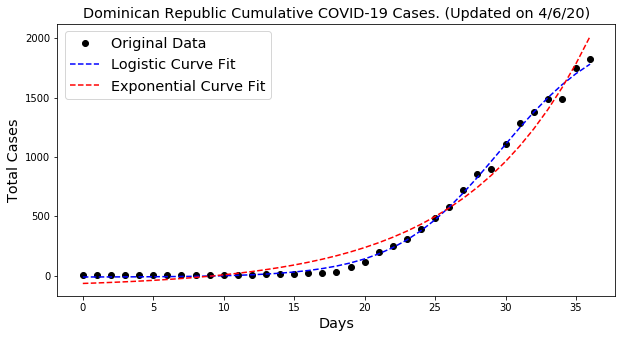



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1755
	Confirmed cases on 3/30/20 	 1212
	Ratio: 1.45
	Weekly increase: 44.8 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.9979168435367712
	Doubling Time (during middle of growth):  10.41 (± 1.01 ) days
	param:  [ 7.99315038e+01  1.33226691e-01 -5.36590727e+01  2.51966111e+03]

** Based on Exponential Fit **

	R^2: 0.983715081169808
	Doubling Time (represents overall growth):  9.09 (± 1.15 ) days
	param:  [ 1.00000000e+02  7.62170678e-02 -1.00000000e+02]


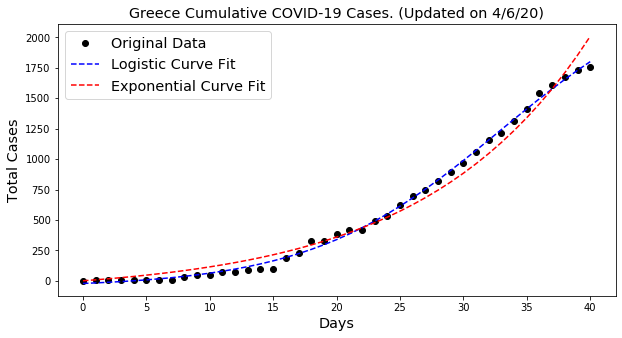



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1686
	Confirmed cases on 3/30/20 	 1326
	Ratio: 1.27
	Weekly increase: 27.1 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.2 days

** Based on Logistic Fit**

	R^2: 0.9944451419691254
	Doubling Time (during middle of growth):  3.62 (± 0.45 ) days
	param:  [2.58222627e+03 3.83374220e-01 6.66809964e+00 1.60453926e+03]

 exponential R^2  0.9130222720792026


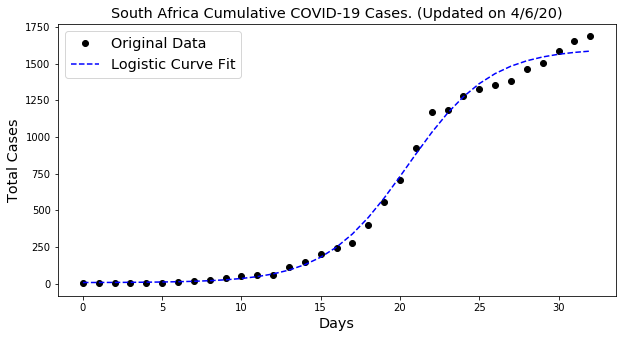



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1579
	Confirmed cases on 3/30/20 	 798
	Ratio: 1.98
	Weekly increase: 97.9 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9981672226174739
	Doubling Time (during middle of growth):  7.41 (± 0.74 ) days
	param:  [ 1.61904805e+02  1.87051518e-01 -3.16572997e+01  2.38635669e+03]

** Based on Exponential Fit **

	R^2: 0.990615601554033
	Doubling Time (represents overall growth):  6.57 (± 0.68 ) days
	param:  [  68.82362371    0.10552179 -100.        ]


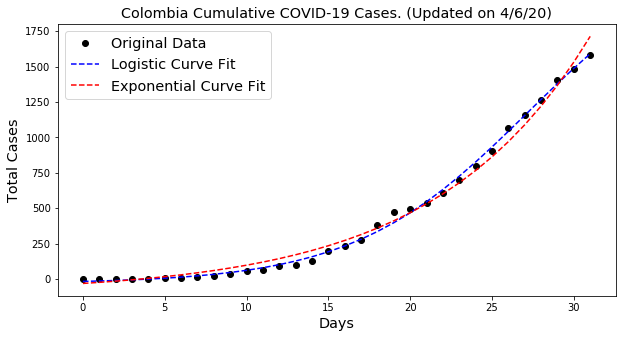



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1562
	Confirmed cases on 3/30/20 	 1086
	Ratio: 1.44
	Weekly increase: 43.8 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9985077476141483
	Doubling Time (during middle of growth):  8.25 (± 0.6 ) days
	param:  [ 1.19029363e+02  1.67995549e-01 -1.95463929e+01  1.83550152e+03]

** Based on Exponential Fit **

	R^2: 0.9778545399437275
	Doubling Time (represents overall growth):  9.03 (± 1.41 ) days
	param:  [ 1.00000000e+02  7.67800048e-02 -1.00000000e+02]


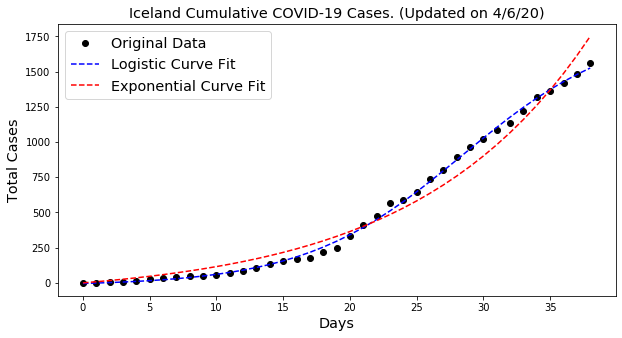



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1554
	Confirmed cases on 3/30/20 	 820
	Ratio: 1.9
	Weekly increase: 89.5 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9968663223395958
	Doubling Time (during middle of growth):  6.42 (± 0.69 ) days
	param:  [ 4.31388283e+02  2.15882014e-01 -1.07088232e+01  1.98435782e+03]

** Based on Exponential Fit **

	R^2: 0.9840450490114179
	Doubling Time (represents overall growth):  6.78 (± 0.85 ) days
	param:  [  56.05087506    0.10215996 -100.        ]


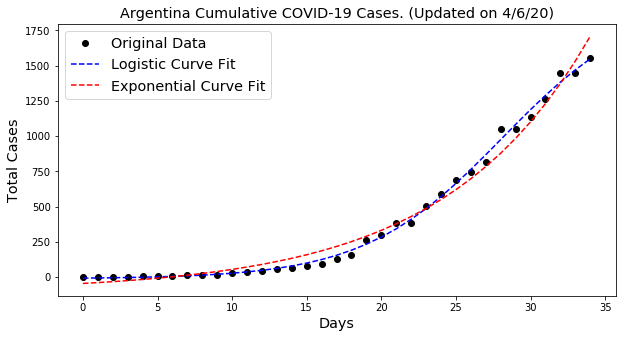



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1423
	Confirmed cases on 3/30/20 	 584
	Ratio: 2.44
	Weekly increase: 143.7 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9968677914467675
	Doubling Time (during middle of growth):  6.87 (± 0.7 ) days
	param:  [2.69407940e+03 2.01815616e-01 3.97124598e+00 2.45809017e+03]

** Based on Exponential Fit **

	R^2: 0.9914723841909661
	Doubling Time (represents overall growth):  5.44 (± 0.37 ) days
	param:  [  8.5141148    0.12731363 -30.49774852]


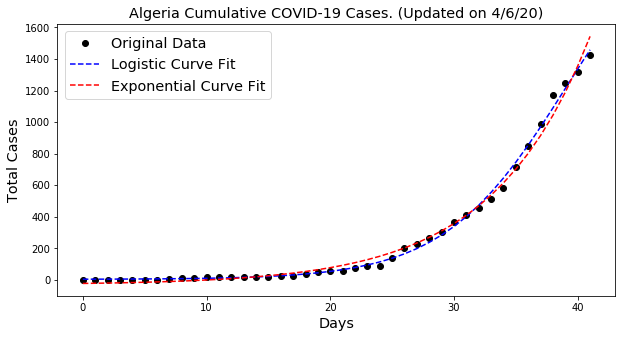



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1375
	Confirmed cases on 3/30/20 	 879
	Ratio: 1.56
	Weekly increase: 56.4 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9958770276749104
	Doubling Time (during middle of growth):  12.79 (± 1.13 ) days
	param:  [3.07496895e+03 1.08384752e-01 3.46252012e+01 2.69785299e+03]

** Based on Exponential Fit **

	R^2: 0.9935440589982355
	Doubling Time (represents overall growth):  9.12 (± 0.39 ) days
	param:  [ 5.10242594  0.07600013 12.16216321]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

overflow encountered in multiply



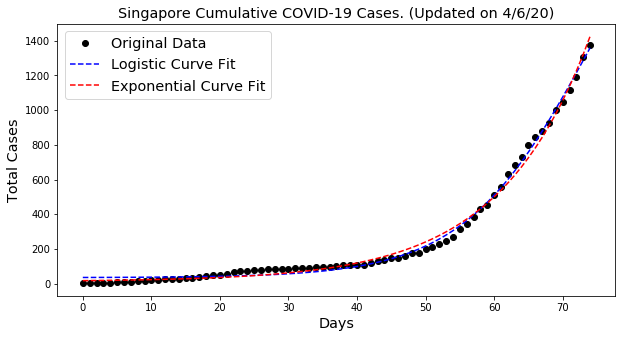



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1322
	Confirmed cases on 3/30/20 	 656
	Ratio: 2.02
	Weekly increase: 101.5 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.995806337601967
	Doubling Time (during middle of growth):  13.77 (± 1.95 ) days
	param:  [ 8.72327359e+02  1.00694254e-01 -2.91011865e+01  7.35556039e+03]

** Based on Exponential Fit **

	R^2: 0.9955851905685954
	Doubling Time (represents overall growth):  7.68 (± 0.34 ) days
	param:  [ 12.2611976    0.09021459 -37.92128729]


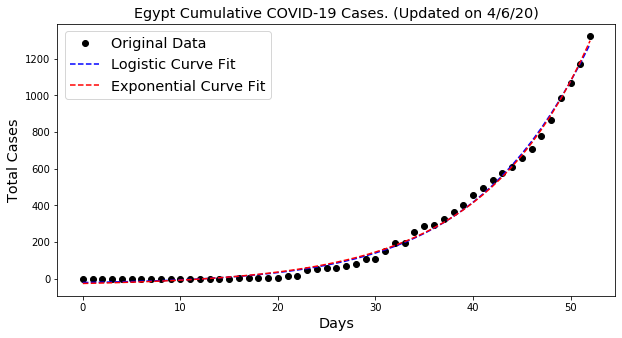



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1319
	Confirmed cases on 3/30/20 	 548
	Ratio: 2.41
	Weekly increase: 140.7 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.998112426920221
	Doubling Time (during middle of growth):  4.4 (± 0.34 ) days
	param:  [ 9.84338969e+03  3.14870589e-01 -1.69768553e+00  1.66428284e+03]

** Based on Exponential Fit **

	R^2: 0.9794094536328717
	Doubling Time (represents overall growth):  4.84 (± 0.58 ) days
	param:  [ 12.08140073   0.14311965 -57.2328669 ]


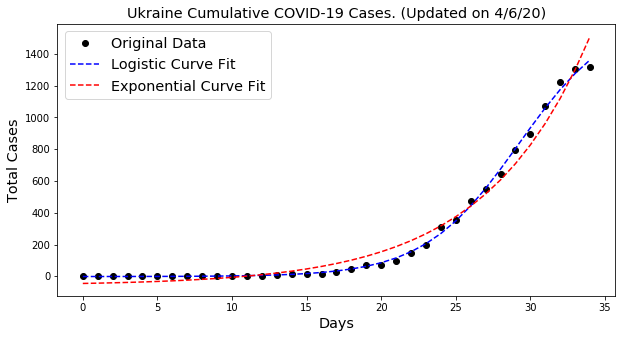



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1222
	Confirmed cases on 3/30/20 	 790
	Ratio: 1.55
	Weekly increase: 54.7 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9989610221988355
	Doubling Time (during middle of growth):  5.84 (± 0.29 ) days
	param:  [ 2.19141033e+03  2.37361716e-01 -1.31747831e+00  1.36618724e+03]

** Based on Exponential Fit **

	R^2: 0.9745795584344833
	Doubling Time (represents overall growth):  7.91 (± 1.1 ) days
	param:  [ 4.07432947e+01  8.76164659e-02 -9.97282803e+01]


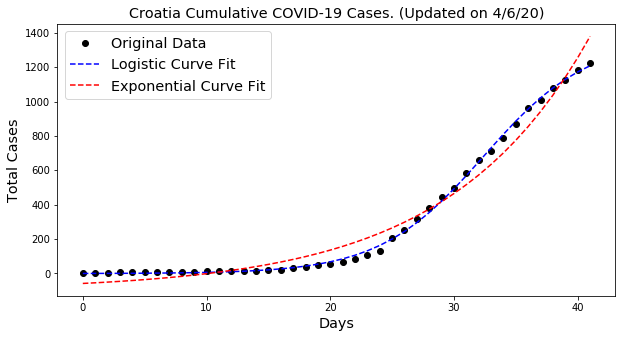



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1120
	Confirmed cases on 3/30/20 	 556
	Ratio: 2.01
	Weekly increase: 101.4 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9969262715344207
	Doubling Time (during middle of growth):  6.97 (± 0.79 ) days
	param:  [ 5.95726139e+02  1.98784014e-01 -1.14371012e+01  1.71649327e+03]

** Based on Exponential Fit **

	R^2: 0.9912071307165523
	Doubling Time (represents overall growth):  5.94 (± 0.49 ) days
	param:  [ 20.56247433   0.11665312 -53.88705471]


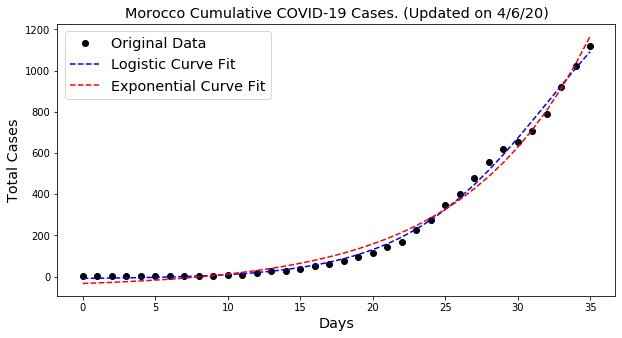



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1108
	Confirmed cases on 3/30/20 	 715
	Ratio: 1.55
	Weekly increase: 55.0 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9922151962293771
	Doubling Time (during middle of growth):  11.7 (± 2.62 ) days
	param:  [ 7.17948228e+01  1.18464055e-01 -5.41717926e+01  1.96081455e+03]

** Based on Exponential Fit **

	R^2: 0.9875642534652902
	Doubling Time (represents overall growth):  9.4 (± 1.09 ) days
	param:  [ 7.33551544e+01  7.37204194e-02 -1.00000000e+02]


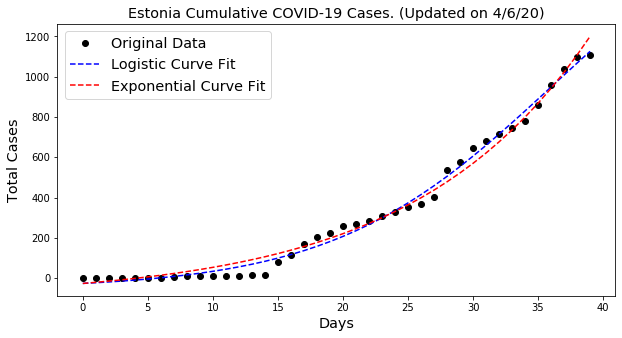



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1106
	Confirmed cases on 3/30/20 	 589
	Ratio: 1.88
	Weekly increase: 87.8 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9971773808601277
	Doubling Time (during middle of growth):  5.08 (± 0.44 ) days
	param:  [ 5.64991405e+03  2.72696242e-01 -5.68032809e+00  1.26392629e+03]

** Based on Exponential Fit **

	R^2: 0.9773656819506074
	Doubling Time (represents overall growth):  5.88 (± 0.72 ) days
	param:  [ 14.44257148   0.11782432 -56.72047437]


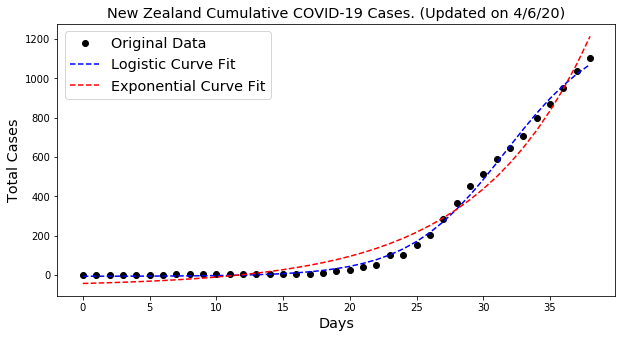



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1031
	Confirmed cases on 3/30/20 	 630
	Ratio: 1.64
	Weekly increase: 63.7 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9980205577445361
	Doubling Time (during middle of growth):  9.92 (± 0.9 ) days
	param:  [2.61367854e+02 1.39798748e-01 6.26089574e+00 1.77036184e+03]

** Based on Exponential Fit **

	R^2: 0.9945816355729595
	Doubling Time (represents overall growth):  8.19 (± 0.52 ) days
	param:  [ 31.90893144   0.08462911 -42.55326552]


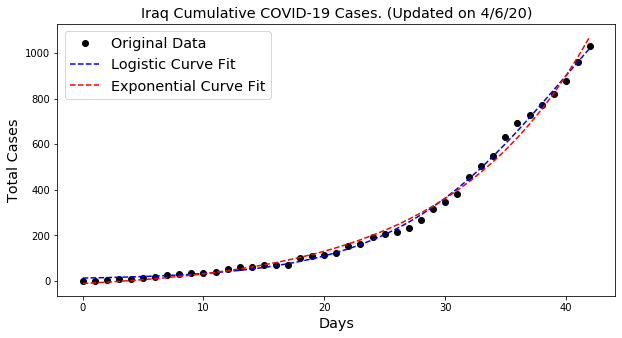



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 1021
	Confirmed cases on 3/30/20 	 756
	Ratio: 1.35
	Weekly increase: 35.1 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.1 days

** Based on Logistic Fit**

	R^2: 0.9968536127816788
	Doubling Time (during middle of growth):  13.82 (± 3.24 ) days
	param:  [ 1.06474943e+01  1.00319069e-01 -1.68929908e+02  1.55968569e+03]

** Based on Exponential Fit **

	R^2: 0.95333405119827
	Doubling Time (represents overall growth):  8.9 (± 2.51 ) days
	param:  [ 1.00000000e+02  7.79064193e-02 -1.91163490e+01]


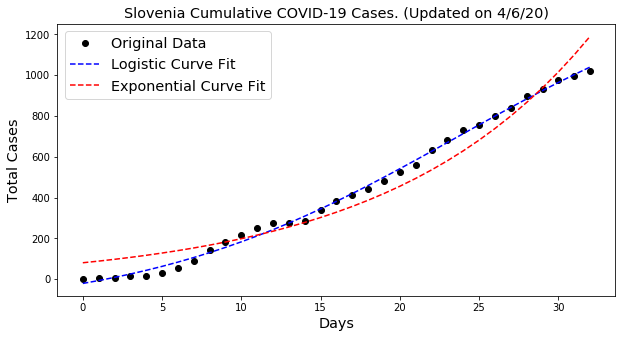



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 965
	Confirmed cases on 3/30/20 	 298
	Ratio: 3.24
	Weekly increase: 223.8 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9976110682707764
	Doubling Time (during middle of growth):  8.67 (± 1.29 ) days
	param:  [ 2.69247902e+08  1.59914561e-01 -8.06428035e+00  2.59087807e+09]

** Based on Exponential Fit **

	R^2: 0.9976110687346376
	Doubling Time (represents overall growth):  4.33 (± 0.19 ) days
	param:  [ 9.62265659  0.15991453 -8.06429135]


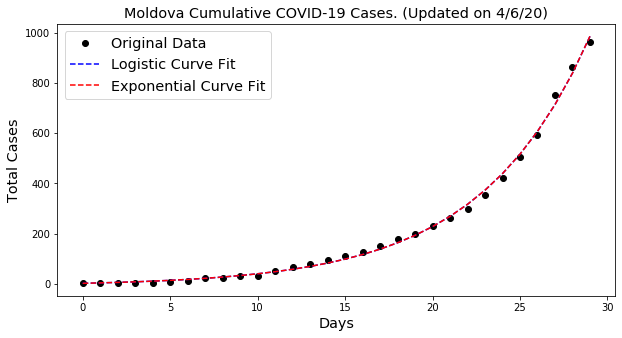



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 843
	Confirmed cases on 3/30/20 	 491
	Ratio: 1.72
	Weekly increase: 71.7 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.99639767905195
	Doubling Time (during middle of growth):  6.01 (± 0.61 ) days
	param:  [ 1.21061701e+03  2.30557881e-01 -1.00149326e+01  9.88024035e+02]

** Based on Exponential Fit **

	R^2: 0.9779785077239211
	Doubling Time (represents overall growth):  7.18 (± 0.96 ) days
	param:  [ 25.51941536   0.09656266 -67.89418361]


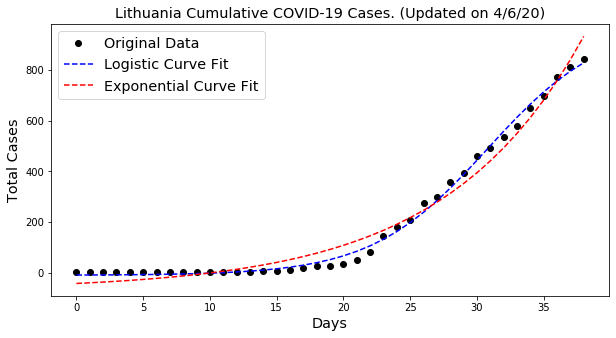



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 833
	Confirmed cases on 3/30/20 	 482
	Ratio: 1.73
	Weekly increase: 72.8 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9965617580268779
	Doubling Time (during middle of growth):  8.48 (± 1.07 ) days
	param:  [ 1.81001002e+02  1.63494790e-01 -2.02996981e+01  1.30033895e+03]

** Based on Exponential Fit **

	R^2: 0.9900997503590327
	Doubling Time (represents overall growth):  8.04 (± 0.81 ) days
	param:  [ 44.6733176    0.08626078 -83.07934296]


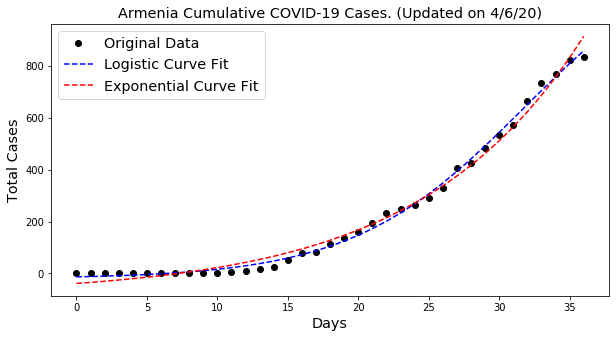



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 756
	Confirmed cases on 3/30/20 	 515
	Ratio: 1.47
	Weekly increase: 46.8 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9939883622514109
	Doubling Time (during middle of growth):  19.4 (± 6.22 ) days
	param:  [ 2.13934226e+01  7.14758497e-02 -6.94135673e+01  1.60910714e+03]

** Based on Exponential Fit **

	R^2: 0.9894799850540261
	Doubling Time (represents overall growth):  13.46 (± 1.69 ) days
	param:  [ 1.00000000e+02  5.14936444e-02 -8.07298221e+01]


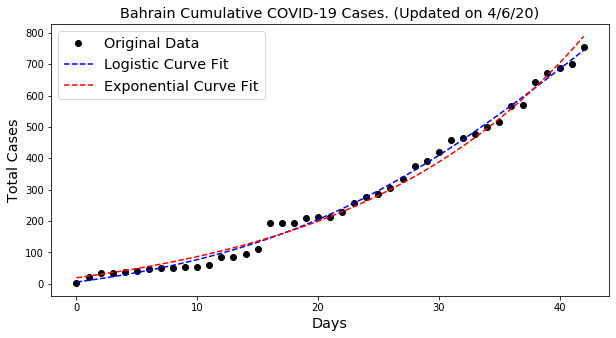



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 744
	Confirmed cases on 3/30/20 	 447
	Ratio: 1.66
	Weekly increase: 66.4 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9993886162913139
	Doubling Time (during middle of growth):  6.7 (± 0.33 ) days
	param:  [ 2.49873698e+02  2.07023221e-01 -3.73248653e+00  9.53392653e+02]

** Based on Exponential Fit **

	R^2: 0.98779666032053
	Doubling Time (represents overall growth):  7.93 (± 0.98 ) days
	param:  [ 50.29081677   0.08737133 -82.13001388]


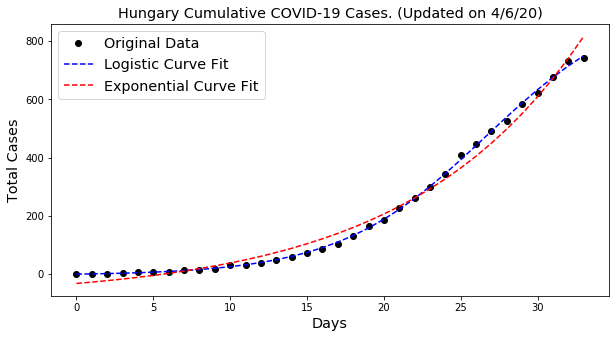



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9962764538123736
	Doubling Time (during middle of growth):  2.82 (± 0.23 ) days
	param:  [9.04143207e+01 4.91862536e-01 6.87921646e+01 7.08406426e+02]

 exponential R^2  -0.46824853313130066


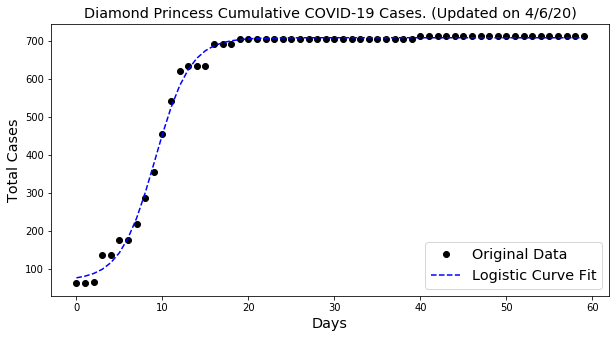



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 700
	Confirmed cases on 3/30/20 	 152
	Ratio: 4.61
	Weekly increase: 360.5 %
	Daily increase: 24.4 % per day
	Doubling Time (represents recent growth): 3.2 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9803669354349209
	Doubling Time (represents overall growth):  2.91 (± 0.28 ) days
	param:  [ 0.0785532   0.23839757 20.60683173]


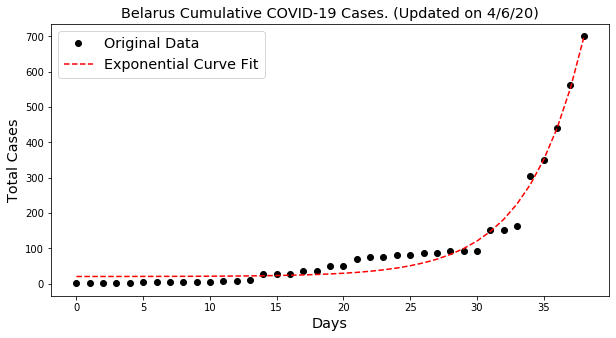



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 674
	Confirmed cases on 3/30/20 	 368
	Ratio: 1.83
	Weekly increase: 83.2 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9975561745094854
	Doubling Time (during middle of growth):  6.85 (± 0.72 ) days
	param:  [ 2.47843892e+02  2.02506766e-01 -3.65604654e+00  9.59713398e+02]

** Based on Exponential Fit **

	R^2: 0.988766736791847
	Doubling Time (represents overall growth):  7.18 (± 0.82 ) days
	param:  [ 36.72851832   0.09649523 -61.96019584]


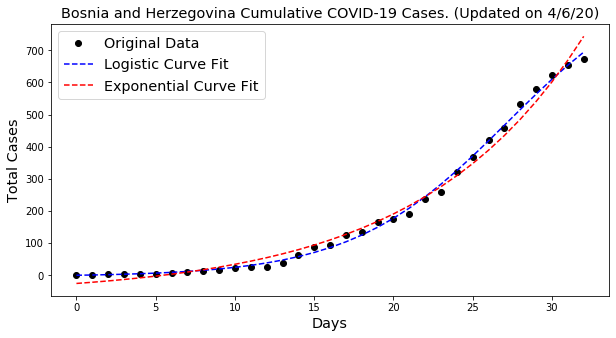



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 665
	Confirmed cases on 3/30/20 	 266
	Ratio: 2.5
	Weekly increase: 150.0 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9705389261921363
	Doubling Time (during middle of growth):  12.81 (± 1.24 ) days
	param:  [1.39723682e+09 1.08184494e-01 4.15094934e+01 8.17686363e+09]

** Based on Exponential Fit **

	R^2: 0.9705389276900548
	Doubling Time (represents overall growth):  6.41 (± 0.85 ) days
	param:  [ 5.85243719  0.10818337 41.50848131]


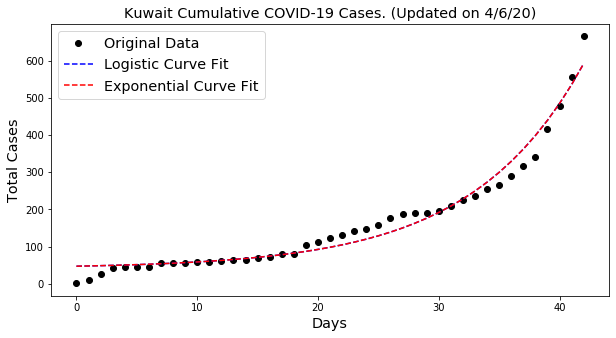



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 662
	Confirmed cases on 3/30/20 	 302
	Ratio: 2.19
	Weekly increase: 119.2 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9926024142877258
	Doubling Time (during middle of growth):  5.8 (± 1.34 ) days
	param:  [1.23859533e+02 2.38972420e-01 8.75325037e-01 8.92634444e+02]

** Based on Exponential Fit **

	R^2: 0.986291603124848
	Doubling Time (represents overall growth):  6.18 (± 1.0 ) days
	param:  [ 50.41343307   0.11207602 -63.45949115]


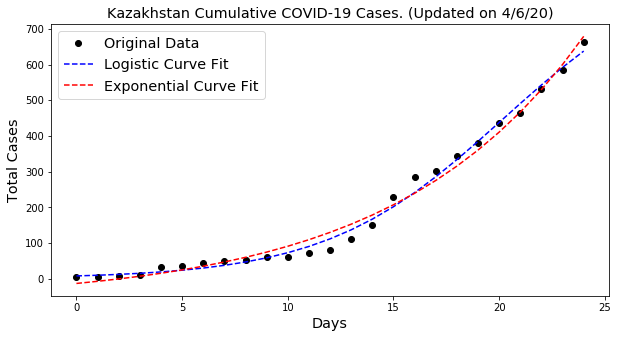



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 658
	Confirmed cases on 3/30/20 	 139
	Ratio: 4.73
	Weekly increase: 373.4 %
	Daily increase: 24.9 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9833005098106004
	Doubling Time (during middle of growth):  3.79 (± 0.97 ) days
	param:  [3.61445674e+04 3.65558437e-01 1.25757553e+01 9.97808500e+02]

** Based on Exponential Fit **

	R^2: 0.9754983912615085
	Doubling Time (represents overall growth):  3.52 (± 0.45 ) days
	param:  [ 1.65383911  0.19707029 -5.46587837]


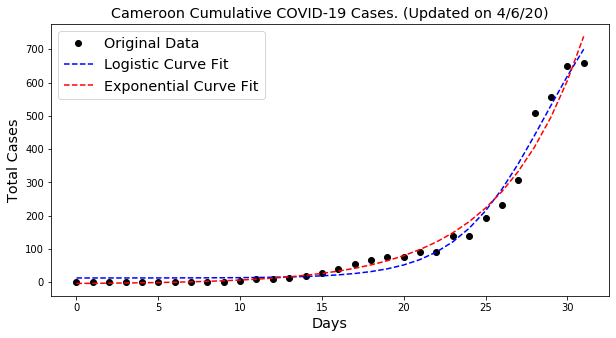



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 641
	Confirmed cases on 3/30/20 	 273
	Ratio: 2.35
	Weekly increase: 134.8 %
	Daily increase: 13.0 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9988916690906009
	Doubling Time (during middle of growth):  6.66 (± 0.45 ) days
	param:  [1.55541454e+03 2.08067484e-01 4.72296492e+00 1.19458983e+03]

** Based on Exponential Fit **

	R^2: 0.9953364089021774
	Doubling Time (represents overall growth):  4.98 (± 0.27 ) days
	param:  [ 4.5666282   0.13906934 -9.39438449]


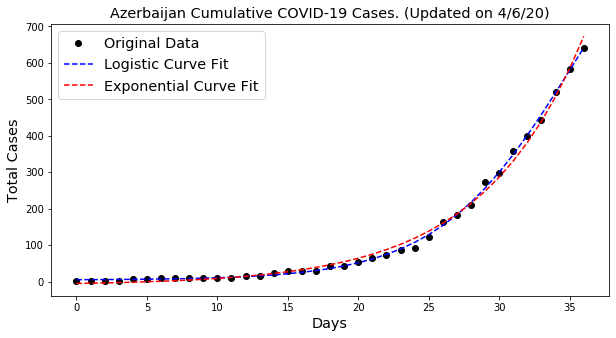



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 596
	Confirmed cases on 3/30/20 	 312
	Ratio: 1.91
	Weekly increase: 91.0 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9975378603868472
	Doubling Time (during middle of growth):  5.8 (± 0.54 ) days
	param:  [ 5.46821284e+02  2.39147160e-01 -1.77247141e+00  7.17730777e+02]

** Based on Exponential Fit **

	R^2: 0.9815666955997366
	Doubling Time (represents overall growth):  7.22 (± 1.03 ) days
	param:  [ 30.16948296   0.0960086  -57.68317842]


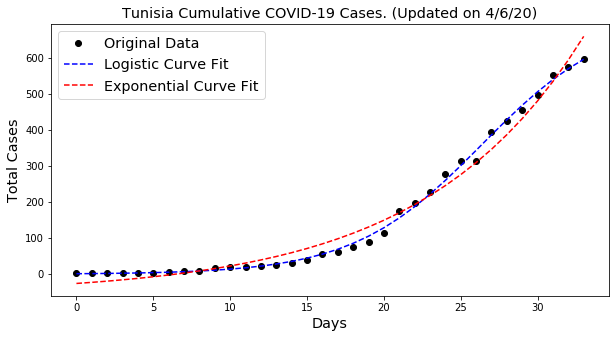



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 570
	Confirmed cases on 3/30/20 	 285
	Ratio: 2.0
	Weekly increase: 100.0 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9950156983333076
	Doubling Time (during middle of growth):  8.96 (± 1.3 ) days
	param:  [ 4.10907668e+02  1.54778183e-01 -1.03695578e+01  1.05605890e+03]

** Based on Exponential Fit **

	R^2: 0.9914332249723928
	Doubling Time (represents overall growth):  6.84 (± 0.52 ) days
	param:  [ 10.901178     0.10135498 -28.47817654]


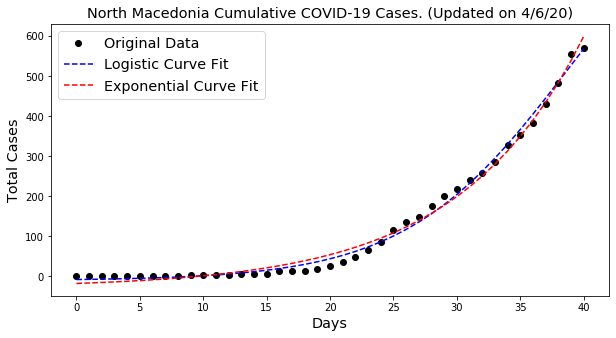



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 549
	Confirmed cases on 3/30/20 	 359
	Ratio: 1.53
	Weekly increase: 52.9 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9979060179252222
	Doubling Time (during middle of growth):  10.06 (± 1.51 ) days
	param:  [ 1.79410800e+01  1.37766220e-01 -5.16710745e+01  7.45701733e+02]

** Based on Exponential Fit **

	R^2: 0.9829426718985574
	Doubling Time (represents overall growth):  10.31 (± 2.19 ) days
	param:  [ 1.00000000e+02  6.72279091e-02 -9.48375477e+01]


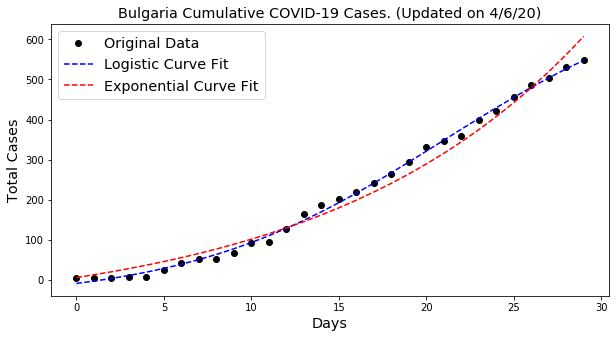



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 542
	Confirmed cases on 3/30/20 	 376
	Ratio: 1.44
	Weekly increase: 44.1 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9990188778488622
	Doubling Time (during middle of growth):  7.0 (± 0.41 ) days
	param:  [ 1.74152351e+02  1.97957622e-01 -8.95846592e+00  6.40468077e+02]

** Based on Exponential Fit **

	R^2: 0.9822860922556771
	Doubling Time (represents overall growth):  10.29 (± 1.72 ) days
	param:  [ 6.66930816e+01  6.73874199e-02 -1.00000000e+02]


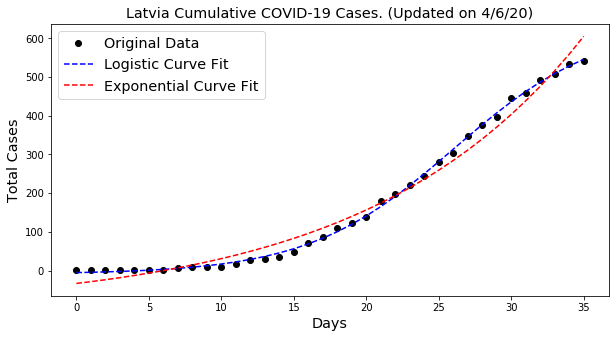



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 541
	Confirmed cases on 3/30/20 	 446
	Ratio: 1.21
	Weekly increase: 21.3 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.1 days

** Based on Logistic Fit**

	R^2: 0.9976514248359473
	Doubling Time (during middle of growth):  6.98 (± 0.49 ) days
	param:  [5.32462786e+02 1.98637253e-01 2.81204690e+00 5.75587913e+02]

** Based on Exponential Fit **

	R^2: 0.9675621793500755
	Doubling Time (represents overall growth):  13.24 (± 2.67 ) days
	param:  [ 6.85878187e+01  5.23345323e-02 -1.00000000e+02]


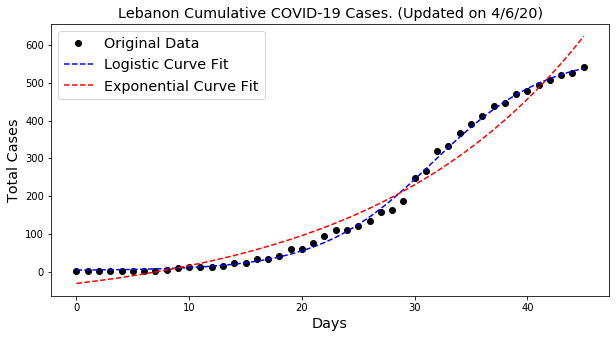



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 534
	Confirmed cases on 3/30/20 	 336
	Ratio: 1.59
	Weekly increase: 58.9 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9960358891737396
	Doubling Time (during middle of growth):  13.8 (± 3.93 ) days
	param:  [ 1.71515439e+01  1.00475900e-01 -7.18453683e+01  9.78580822e+02]

** Based on Exponential Fit **

	R^2: 0.9909202381356446
	Doubling Time (represents overall growth):  11.24 (± 1.71 ) days
	param:  [ 9.70692241e+01  6.16470353e-02 -1.00000000e+02]


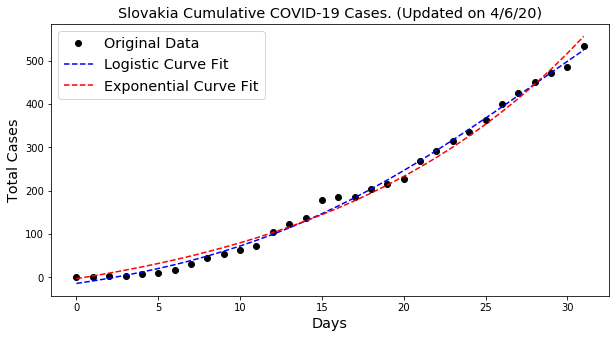



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 525
	Confirmed cases on 3/30/20 	 370
	Ratio: 1.42
	Weekly increase: 41.9 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 13.9 days

** Based on Logistic Fit**

	R^2: 0.996629485548454
	Doubling Time (during middle of growth):  5.59 (± 0.55 ) days
	param:  [ 5.33786985e+02  2.48077036e-01 -7.43192803e+00  5.45926383e+02]

** Based on Exponential Fit **

	R^2: 0.9700075702679705
	Doubling Time (represents overall growth):  9.53 (± 1.96 ) days
	param:  [ 5.22151142e+01  7.27075965e-02 -9.04922205e+01]


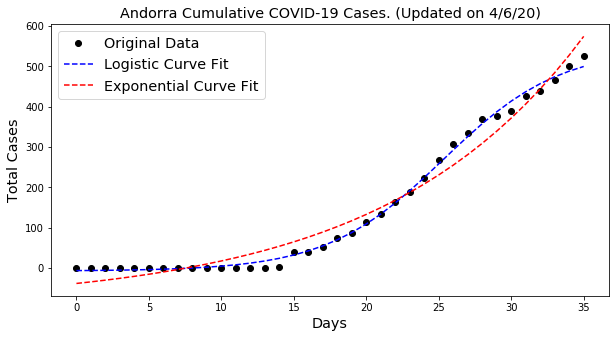



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 467
	Confirmed cases on 3/30/20 	 330
	Ratio: 1.42
	Weekly increase: 41.5 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 14.0 days

** Based on Logistic Fit**

	R^2: 0.9986026168746012
	Doubling Time (during middle of growth):  6.55 (± 0.49 ) days
	param:  [ 8.36584316e+01  2.11741837e-01 -6.39457556e+00  5.14043095e+02]

** Based on Exponential Fit **

	R^2: 0.9781818453285589
	Doubling Time (represents overall growth):  10.91 (± 2.52 ) days
	param:  [ 8.67232619e+01  6.35104704e-02 -1.00000000e+02]


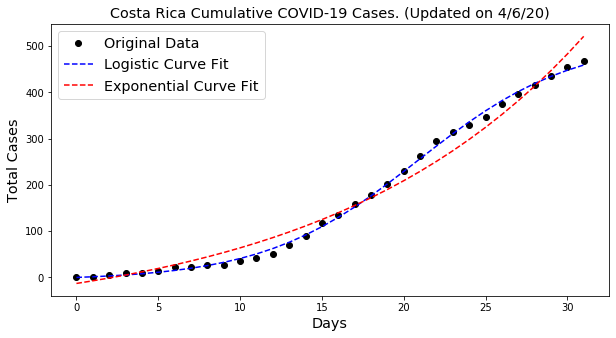



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 465
	Confirmed cases on 3/30/20 	 230
	Ratio: 2.02
	Weekly increase: 102.2 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9946886954584835
	Doubling Time (during middle of growth):  9.77 (± 2.57 ) days
	param:  [ 6.10960935e+01  1.41941100e-01 -1.21566529e+01  1.05557231e+03]

** Based on Exponential Fit **

	R^2: 0.9932758324986672
	Doubling Time (represents overall growth):  7.77 (± 0.85 ) days
	param:  [ 44.89924812   0.08919819 -48.78831257]


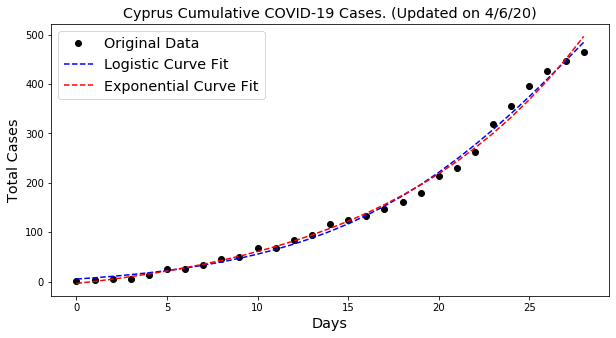



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 457
	Confirmed cases on 3/30/20 	 149
	Ratio: 3.07
	Weekly increase: 206.7 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9806714270392498
	Doubling Time (during middle of growth):  8.49 (± 1.41 ) days
	param:  [8.19096506e+08 1.63315435e-01 2.56932184e+00 9.32265078e+09]

** Based on Exponential Fit **

	R^2: 0.980671427653576
	Doubling Time (represents overall growth):  4.24 (± 0.71 ) days
	param:  [11.38185052  0.16331455  2.56879361]


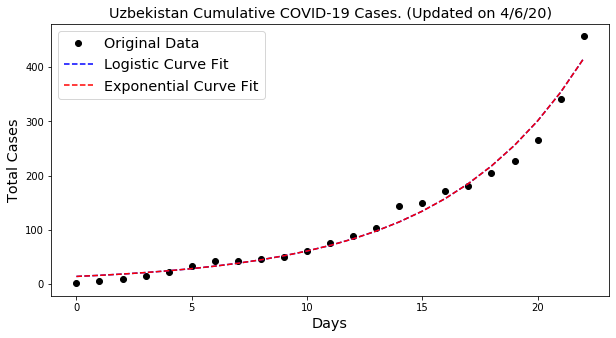



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 406
	Confirmed cases on 3/30/20 	 310
	Ratio: 1.31
	Weekly increase: 31.0 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.9947938890454301
	Doubling Time (during middle of growth):  8.71 (± 2.56 ) days
	param:  [ 5.37212900e+00  1.59203358e-01 -9.70901895e+01  4.79672350e+02]

 exponential R^2  0.9275458998350439


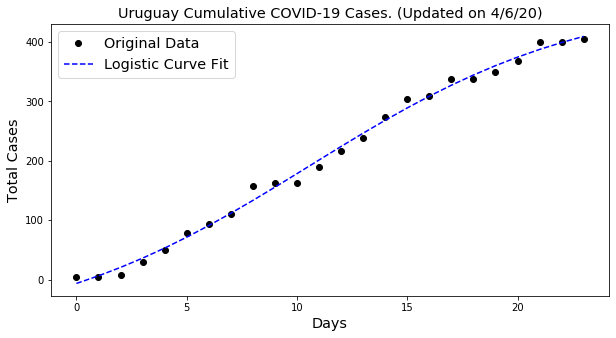



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 377
	Confirmed cases on 3/30/20 	 223
	Ratio: 1.69
	Weekly increase: 69.1 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9955463261432105
	Doubling Time (during middle of growth):  12.47 (± 4.02 ) days
	param:  [ 2.29137420e+01  1.11213068e-01 -2.62981108e+01  7.85948341e+02]

** Based on Exponential Fit **

	R^2: 0.9946340537029491
	Doubling Time (represents overall growth):  11.3 (± 1.5 ) days
	param:  [ 8.38239245e+01  6.13340210e-02 -8.20589527e+01]


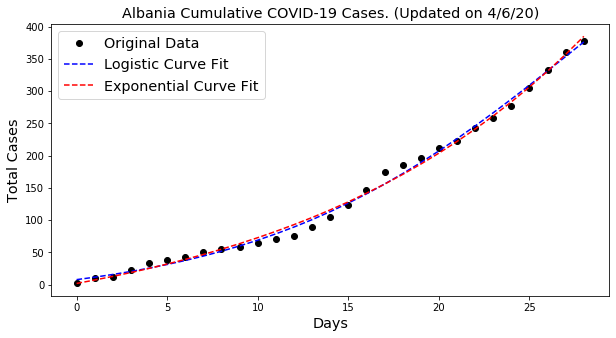



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 373
	Confirmed cases on 3/30/20 	 306
	Ratio: 1.22
	Weekly increase: 21.9 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.5 days

** Based on Logistic Fit**

	R^2: 0.9926272923828269
	Doubling Time (during middle of growth):  6.72 (± 0.64 ) days
	param:  [3.47624383e+05 2.06228125e-01 1.93286834e+01 3.91809794e+02]

** Based on Exponential Fit **

	R^2: 0.9651838885740295
	Doubling Time (represents overall growth):  10.5 (± 1.09 ) days
	param:  [ 3.06464983  0.06598887 -0.95477418]


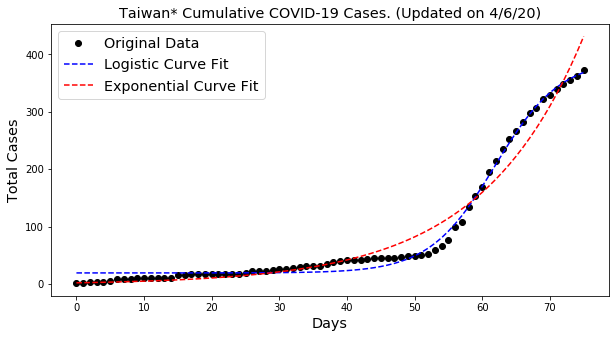



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 367
	Confirmed cases on 3/30/20 	 170
	Ratio: 2.16
	Weekly increase: 115.9 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9939172060944895
	Doubling Time (during middle of growth):  6.56 (± 0.89 ) days
	param:  [4.10684979e+03 2.11462310e-01 1.45884355e+00 5.82401229e+02]

** Based on Exponential Fit **

	R^2: 0.9874901805572097
	Doubling Time (represents overall growth):  5.43 (± 0.44 ) days
	param:  [ 1.89833186  0.12762291 -7.58120383]


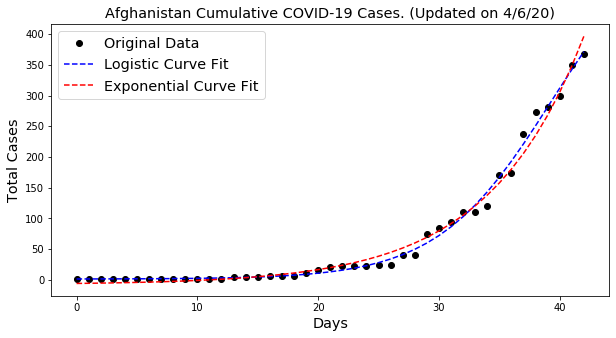



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 364
	Confirmed cases on 3/30/20 	 246
	Ratio: 1.48
	Weekly increase: 48.0 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.4 days

** Based on Logistic Fit**

	R^2: 0.99683272333435
	Doubling Time (during middle of growth):  6.18 (± 0.78 ) days
	param:  [ 5.02619481e+01  2.24252831e-01 -1.46584170e+01  3.90202281e+02]

** Based on Exponential Fit **

	R^2: 0.9773378088629062
	Doubling Time (represents overall growth):  10.77 (± 3.03 ) days
	param:  [ 8.70303846e+01  6.43497982e-02 -1.00000000e+02]


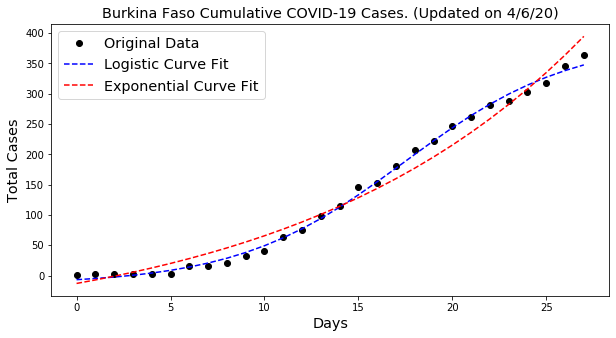



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 350
	Confirmed cases on 3/30/20 	 170
	Ratio: 2.06
	Weekly increase: 105.9 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9978748258126605
	Doubling Time (during middle of growth):  5.68 (± 0.65 ) days
	param:  [ 1.52399747e+02  2.44079599e-01 -2.96552357e+00  4.61506849e+02]

** Based on Exponential Fit **

	R^2: 0.9893286031478514
	Doubling Time (represents overall growth):  6.37 (± 0.88 ) days
	param:  [ 26.81757188   0.10886057 -39.52619999]


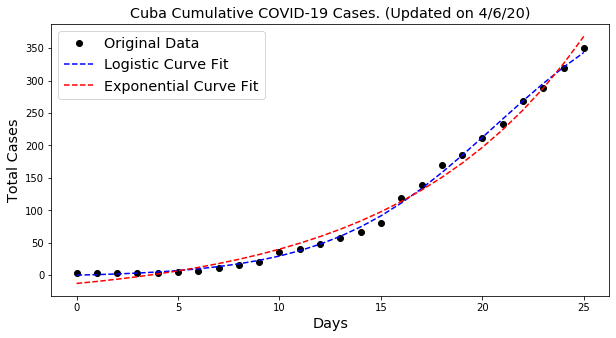



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 349
	Confirmed cases on 3/30/20 	 268
	Ratio: 1.3
	Weekly increase: 30.2 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.4 days

** Based on Logistic Fit**

	R^2: 0.994838054748195
	Doubling Time (during middle of growth):  5.42 (± 0.65 ) days
	param:  [ 2.58608768e+02  2.55989909e-01 -7.09670720e+00  3.46609478e+02]

** Based on Exponential Fit **

	R^2: 0.9588305151907636
	Doubling Time (represents overall growth):  12.51 (± 3.95 ) days
	param:  [ 7.51333299e+01  5.54009217e-02 -1.00000000e+02]


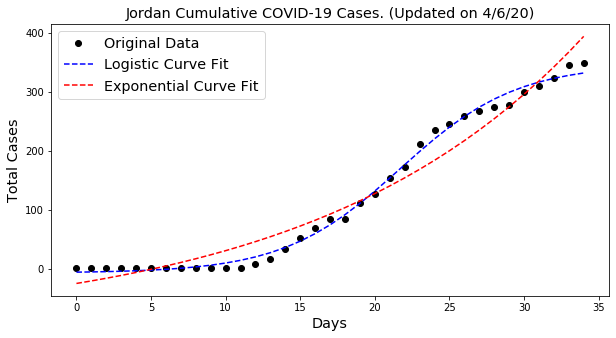



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 331
	Confirmed cases on 3/30/20 	 179
	Ratio: 1.85
	Weekly increase: 84.9 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.996876662559461
	Doubling Time (during middle of growth):  8.2 (± 0.85 ) days
	param:  [7.32907022e+02 1.69009564e-01 5.62743838e+00 5.12392521e+02]

** Based on Exponential Fit **

	R^2: 0.9919319027093094
	Doubling Time (represents overall growth):  6.85 (± 0.48 ) days
	param:  [ 4.96173181  0.10117076 -5.68483744]


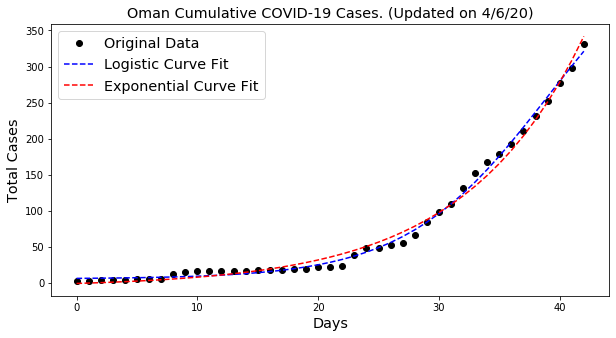



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 323
	Confirmed cases on 3/30/20 	 168
	Ratio: 1.92
	Weekly increase: 92.3 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9782856475730407
	Doubling Time (during middle of growth):  7.04 (± 2.89 ) days
	param:  [ 6.41581285e+01  1.96931693e-01 -1.49272544e+01  4.08693732e+02]

** Based on Exponential Fit **

	R^2: 0.9727162810002886
	Doubling Time (represents overall growth):  7.89 (± 1.96 ) days
	param:  [ 37.37835531   0.08784676 -54.58247158]


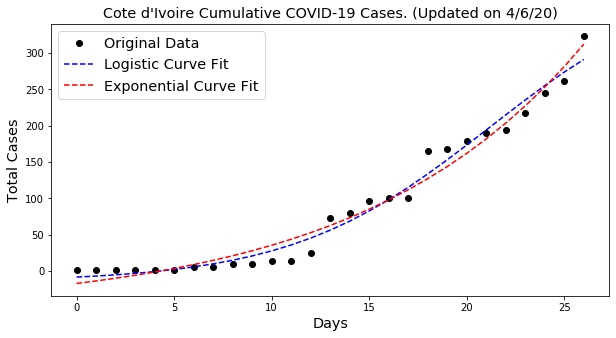



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 298
	Confirmed cases on 3/30/20 	 139
	Ratio: 2.14
	Weekly increase: 114.4 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9953531339947269
	Doubling Time (during middle of growth):  5.03 (± 0.77 ) days
	param:  [3.71447416e+02 2.75802393e-01 2.26383188e+00 3.79477476e+02]

** Based on Exponential Fit **

	R^2: 0.9841261921665452
	Doubling Time (represents overall growth):  5.75 (± 0.87 ) days
	param:  [ 14.96638452   0.12048964 -23.82296443]


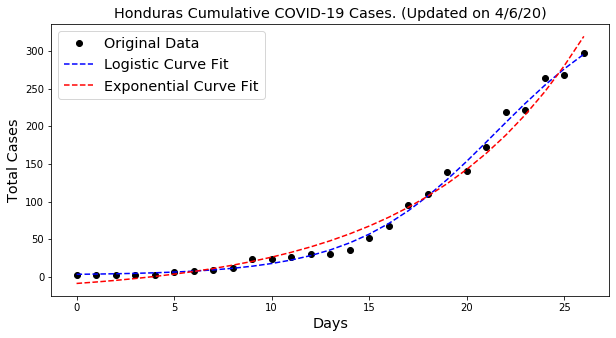



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 266
	Confirmed cases on 3/30/20 	 230
	Ratio: 1.16
	Weekly increase: 15.7 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.4 days

** Based on Logistic Fit**

	R^2: 0.995764499958589
	Doubling Time (during middle of growth):  9.37 (± 1.15 ) days
	param:  [ 2.14517128e+01  1.47911980e-01 -1.53376205e+01  2.80756026e+02]

** Based on Exponential Fit **

	R^2: 0.9551778394997581
	Doubling Time (represents overall growth):  19.36 (± 7.8 ) days
	param:  [ 1.00000000e+02  3.58084338e-02 -9.41198045e+01]


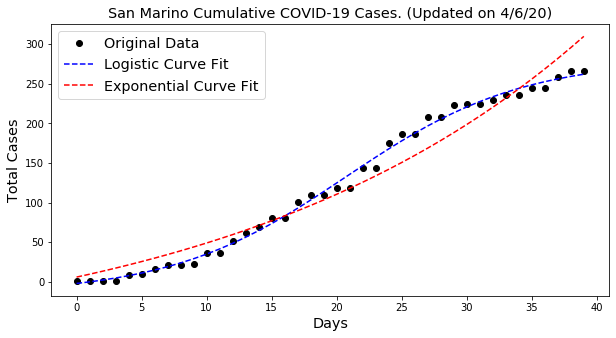



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 254
	Confirmed cases on 3/30/20 	 116
	Ratio: 2.19
	Weekly increase: 119.0 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9896360240048143
	Doubling Time (during middle of growth):  11.37 (± 1.6 ) days
	param:  [6.26114086e+08 1.21951637e-01 1.33861283e+01 3.11877145e+09]

** Based on Exponential Fit **

	R^2: 0.989636024257216
	Doubling Time (represents overall growth):  5.68 (± 0.55 ) days
	param:  [ 4.98115783  0.12195162 13.38612198]


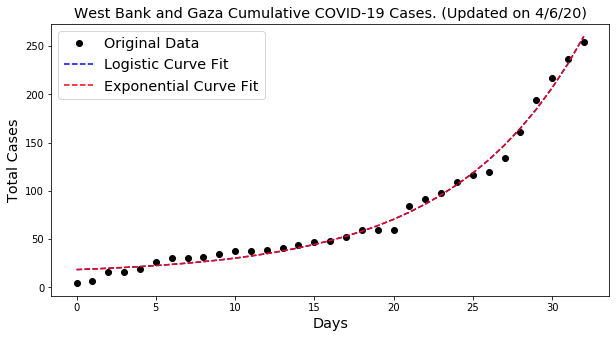



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 253
	Confirmed cases on 3/30/20 	 27
	Ratio: 9.37
	Weekly increase: 837.0 %
	Daily increase: 37.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.9897083021121351
	Doubling Time (during middle of growth):  3.96 (± 1.46 ) days
	param:  [ 6.25874204e+02  3.49634991e-01 -1.36406017e+00  6.53080972e+02]

** Based on Exponential Fit **

	R^2: 0.9884017995755023
	Doubling Time (represents overall growth):  2.6 (± 0.35 ) days
	param:  [ 2.77275103  0.26659801 -5.5748878 ]


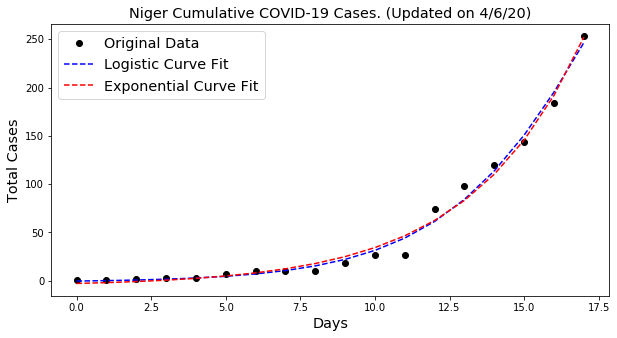



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 245
	Confirmed cases on 3/30/20 	 203
	Ratio: 1.21
	Weekly increase: 20.7 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.8 days

** Based on Logistic Fit**

	R^2: 0.9963513015170726
	Doubling Time (during middle of growth):  8.8 (± 0.61 ) days
	param:  [1.93587424e+04 1.57600626e-01 9.76302606e+00 2.92467182e+02]

** Based on Exponential Fit **

	R^2: 0.9765534897810776
	Doubling Time (represents overall growth):  10.45 (± 0.89 ) days
	param:  [ 2.12188858  0.06630562 -1.28094633]


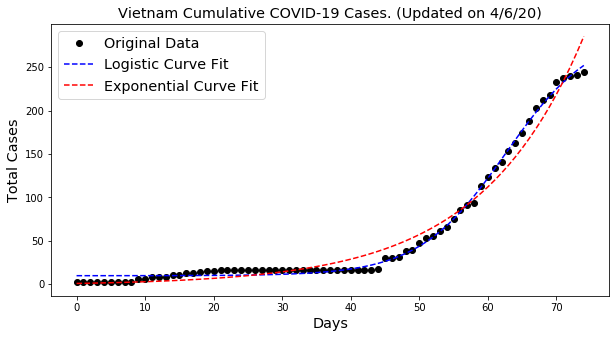



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 244
	Confirmed cases on 3/30/20 	 128
	Ratio: 1.91
	Weekly increase: 90.6 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9941261255160185
	Doubling Time (during middle of growth):  11.79 (± 8.86 ) days
	param:  [ 8.03787465e+00  1.17574400e-01 -6.61968578e+01  5.02774281e+02]

** Based on Exponential Fit **

	R^2: 0.9914172051554322
	Doubling Time (represents overall growth):  10.54 (± 2.89 ) days
	param:  [ 1.00000000e+02  6.57583066e-02 -9.92875222e+01]


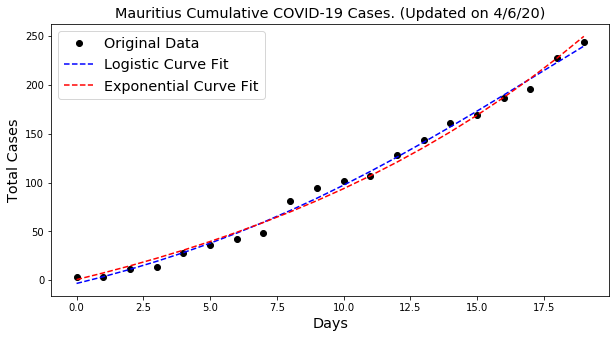



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 241
	Confirmed cases on 3/30/20 	 156
	Ratio: 1.54
	Weekly increase: 54.5 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.992550931208575
	Doubling Time (during middle of growth):  9.83 (± 2.53 ) days
	param:  [ 1.56276120e+01  1.41013103e-01 -2.41582116e+01  2.87214406e+02]

** Based on Exponential Fit **

	R^2: 0.9838631040432583
	Doubling Time (represents overall growth):  15.81 (± 4.51 ) days
	param:  [ 9.42241748e+01  4.38550418e-02 -1.00000000e+02]


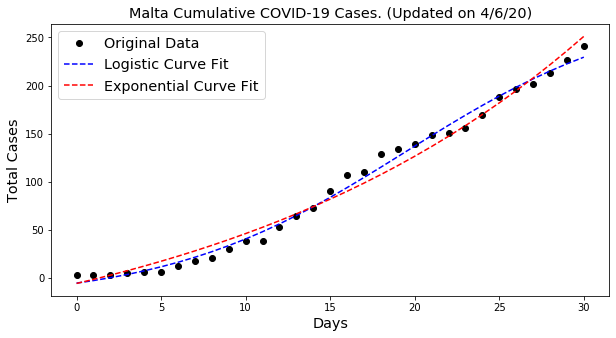



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 238
	Confirmed cases on 3/30/20 	 131
	Ratio: 1.82
	Weekly increase: 81.7 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9975315991882334
	Doubling Time (during middle of growth):  5.21 (± 0.43 ) days
	param:  [4.74265877e+03 2.65880069e-01 1.20573481e-01 2.88587246e+02]

** Based on Exponential Fit **

	R^2: 0.9776456747816172
	Doubling Time (represents overall growth):  6.05 (± 0.75 ) days
	param:  [  3.64073891   0.11453062 -12.4432463 ]


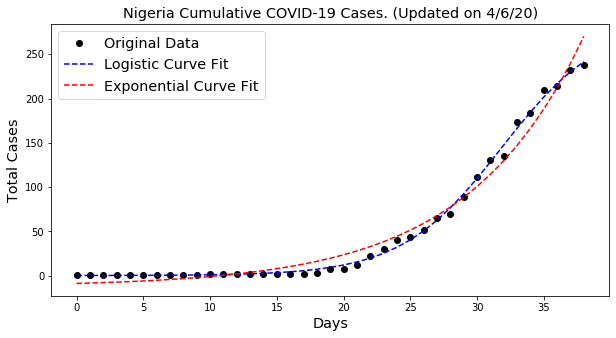



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 233
	Confirmed cases on 3/30/20 	 91
	Ratio: 2.56
	Weekly increase: 156.0 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9894429974936467
	Doubling Time (during middle of growth):  15.22 (± 6.12 ) days
	param:  [ 1.88787659e+07  9.10575637e-02 -4.68782528e+01  8.66000352e+08]

** Based on Exponential Fit **

	R^2: 0.9894429979525032
	Doubling Time (represents overall growth):  7.61 (± 1.61 ) days
	param:  [ 45.87167194   0.09105754 -46.87826206]


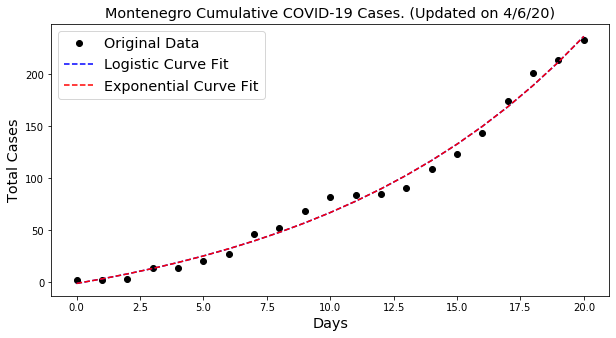



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 226
	Confirmed cases on 3/30/20 	 162
	Ratio: 1.4
	Weekly increase: 39.5 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.9978408269654762
	Doubling Time (during middle of growth):  6.69 (± 0.56 ) days
	param:  [ 2.07401035e+02  2.07253902e-01 -4.94678097e-01  2.62692420e+02]

** Based on Exponential Fit **

	R^2: 0.9788367170327942
	Doubling Time (represents overall growth):  10.6 (± 1.98 ) days
	param:  [ 30.11190876   0.0654178  -42.93240223]


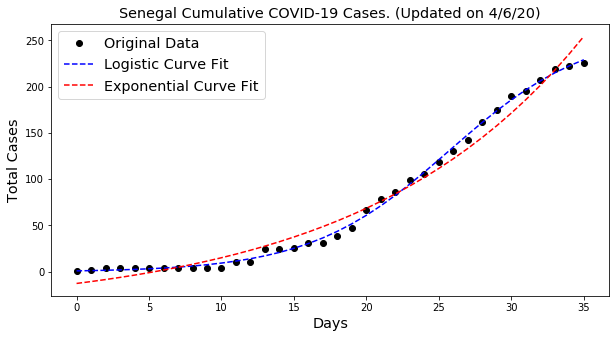



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 216
	Confirmed cases on 3/30/20 	 94
	Ratio: 2.3
	Weekly increase: 129.8 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9691752316992359
	Doubling Time (during middle of growth):  17.44 (± nan ) days
	param:  [ 7.54450041e+06  7.94963371e-02 -5.41637890e+01  4.05290506e+08]

** Based on Exponential Fit **

	R^2: 0.9691752333612155
	Doubling Time (represents overall growth):  8.72 (± 3.84 ) days
	param:  [ 53.71955286   0.07949665 -54.16326688]


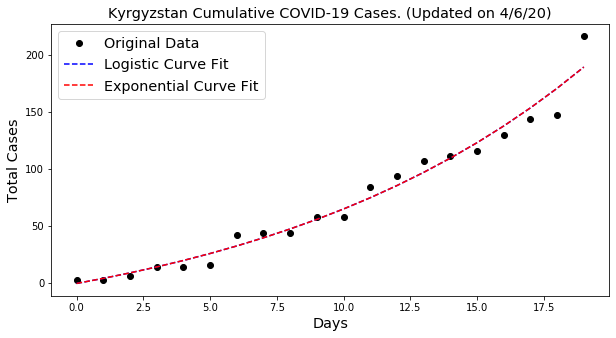



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 214
	Confirmed cases on 3/30/20 	 152
	Ratio: 1.41
	Weekly increase: 40.8 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.9810441527063476
	Doubling Time (during middle of growth):  3.56 (± 0.99 ) days
	param:  [111.81357145   0.38939788  -1.94537885 211.21804822]

 exponential R^2  0.9239229046680099


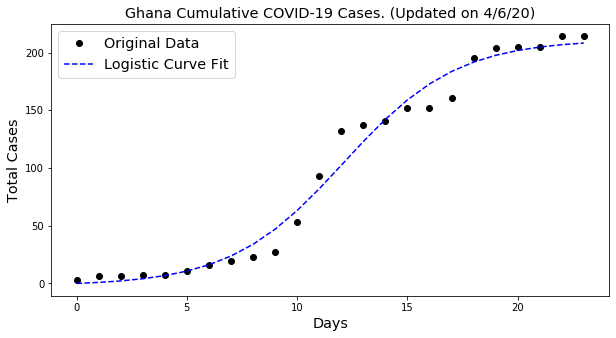



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 188
	Confirmed cases on 3/30/20 	 103
	Ratio: 1.83
	Weekly increase: 82.5 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9953314379550058
	Doubling Time (during middle of growth):  18.83 (± 2.82 ) days
	param:  [ 1.14223505e+08  7.36380467e-02 -1.11373830e+01  1.18626789e+09]

** Based on Exponential Fit **

	R^2: 0.9953314384066645
	Doubling Time (represents overall growth):  9.41 (± 0.64 ) days
	param:  [ 10.38548387   0.07363808 -11.13735658]


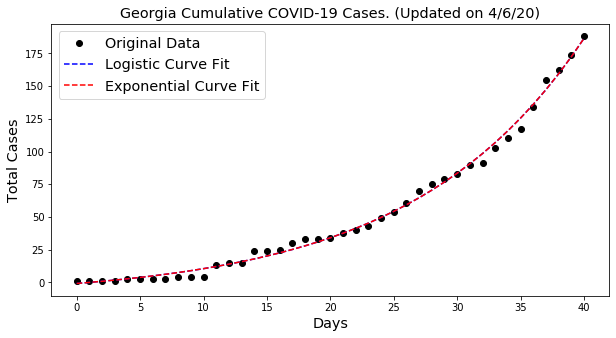



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 183
	Confirmed cases on 3/30/20 	 97
	Ratio: 1.89
	Weekly increase: 88.7 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9912052924856097
	Doubling Time (during middle of growth):  6.23 (± 1.47 ) days
	param:  [1.05626245e+02 2.22522110e-01 1.50065019e+00 2.25144520e+02]

** Based on Exponential Fit **

	R^2: 0.9842112360073678
	Doubling Time (represents overall growth):  7.31 (± 1.3 ) days
	param:  [ 17.25271458   0.09476913 -19.91891544]


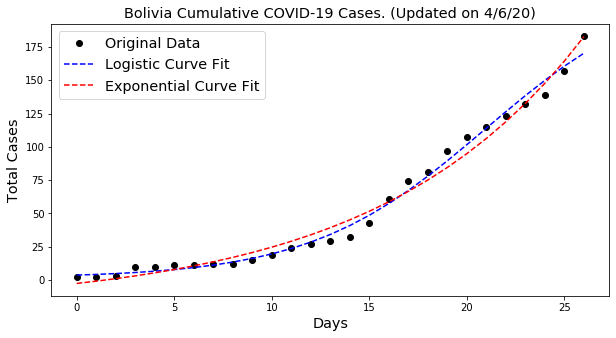



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 178
	Confirmed cases on 3/30/20 	 122
	Ratio: 1.46
	Weekly increase: 45.9 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.9858288178024947
	Doubling Time (during middle of growth):  6.98 (± 0.95 ) days
	param:  [ 7.61191212e+04  1.98678664e-01 -8.45491213e-01  1.77694160e+02]

** Based on Exponential Fit **

	R^2: 0.9521223899110705
	Doubling Time (represents overall growth):  9.77 (± 1.24 ) days
	param:  [ 1.47138613  0.07093559 -8.16566932]


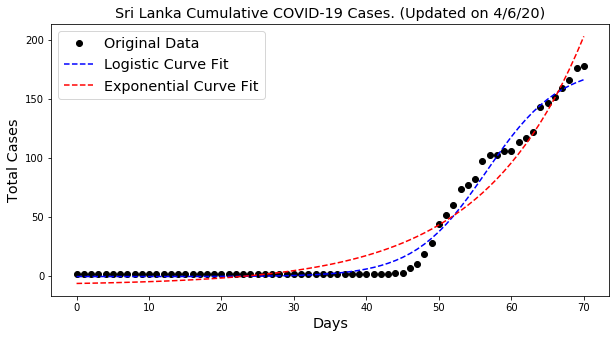



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 165
	Confirmed cases on 3/30/20 	 135
	Ratio: 1.22
	Weekly increase: 22.2 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.2 days

** Based on Logistic Fit**

	R^2: 0.9944723674451382
	Doubling Time (during middle of growth):  11.47 (± 5.24 ) days
	param:  [ 2.14659691e+00  1.20864493e-01 -8.77882465e+01  1.97635044e+02]

 exponential R^2  0.9436347144334403


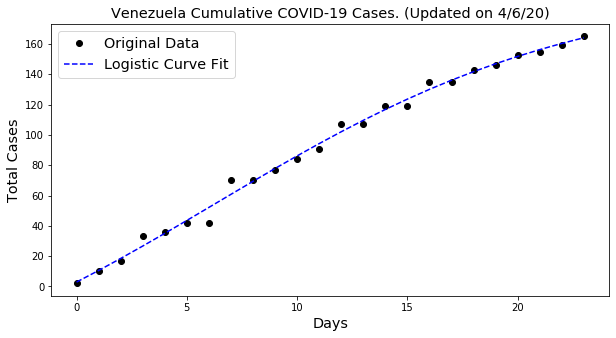



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 161
	Confirmed cases on 3/30/20 	 81
	Ratio: 1.99
	Weekly increase: 98.8 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9896439127261649
	Doubling Time (during middle of growth):  7.92 (± 2.53 ) days
	param:  [ 5.21281010e+01  1.75047722e-01 -6.14538183e+00  2.63035902e+02]

** Based on Exponential Fit **

	R^2: 0.9853314979182558
	Doubling Time (represents overall growth):  8.35 (± 1.58 ) days
	param:  [ 23.67159619   0.08296592 -29.9628848 ]


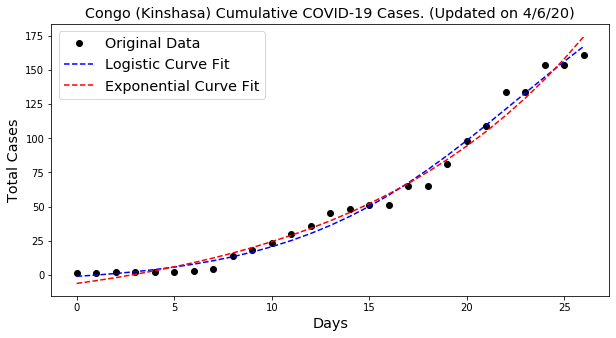



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 158
	Confirmed cases on 3/30/20 	 50
	Ratio: 3.16
	Weekly increase: 216.0 %
	Daily increase: 17.9 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9886139369838307
	Doubling Time (during middle of growth):  5.53 (± 1.59 ) days
	param:  [2.50327743e+02 2.50751429e-01 1.94691568e+00 2.55948965e+02]

** Based on Exponential Fit **

	R^2: 0.9840822027001869
	Doubling Time (represents overall growth):  4.99 (± 0.76 ) days
	param:  [ 6.2493112   0.13879479 -7.90925669]


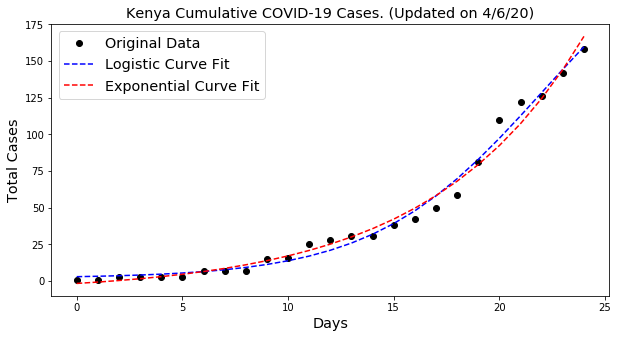



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 145
	Confirmed cases on 3/30/20 	 94
	Ratio: 1.54
	Weekly increase: 54.3 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9667832089741425
	Doubling Time (during middle of growth):  6.72 (± 15.98 ) days
	param:  [  2.06634817   0.20629724  27.20342422 171.61457363]

 exponential R^2  0.9490233078896948


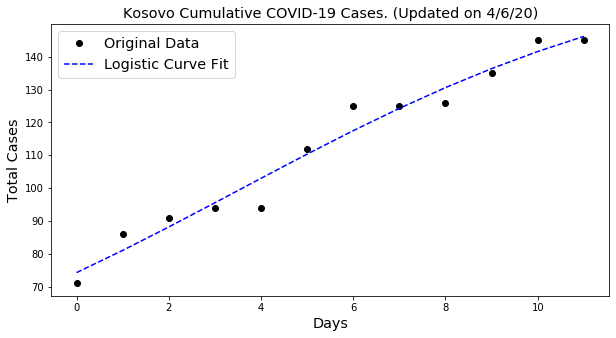



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 135
	Confirmed cases on 3/30/20 	 127
	Ratio: 1.06
	Weekly increase: 6.3 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 79.4 days

** Based on Logistic Fit**

	R^2: 0.9931245223356063
	Doubling Time (during middle of growth):  10.74 (± 3.47 ) days
	param:  [ 1.57855932e+00  1.29076354e-01 -9.84691551e+01  1.48424476e+02]

 exponential R^2  0.8811492839993736


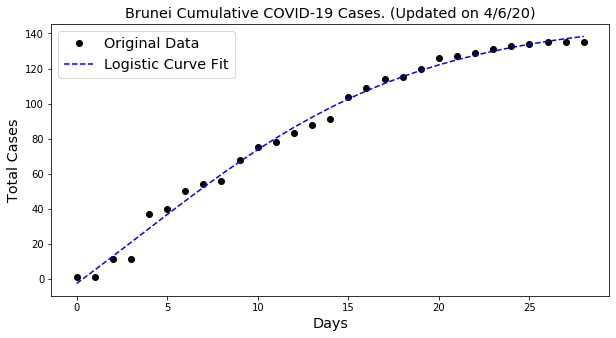



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 128
	Confirmed cases on 3/30/20 	 22
	Ratio: 5.82
	Weekly increase: 481.8 %
	Daily increase: 28.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9906070371185811
	Doubling Time (during middle of growth):  2.19 (± 0.45 ) days
	param:  [5.88460866e+05 6.33393495e-01 2.80778810e+00 1.51787286e+02]

** Based on Exponential Fit **

	R^2: 0.9679629059717375
	Doubling Time (represents overall growth):  2.81 (± 0.48 ) days
	param:  [ 0.39097801  0.24688912 -1.94878075]


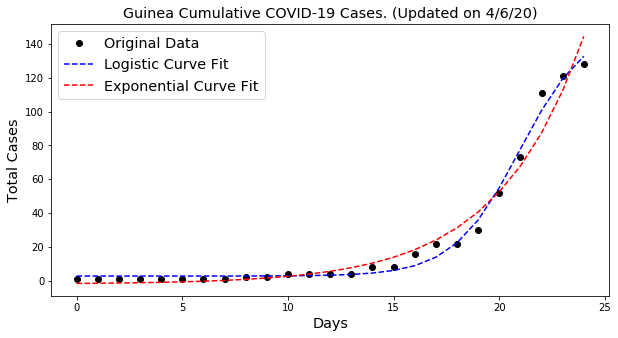



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 123
	Confirmed cases on 3/30/20 	 49
	Ratio: 2.51
	Weekly increase: 151.0 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

 logistic R^2  0.9292056307285137

 exponential R^2  0.929205633798559


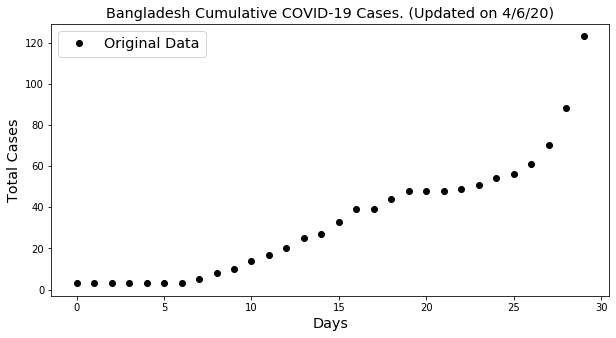



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 114
	Confirmed cases on 3/30/20 	 107
	Ratio: 1.07
	Weekly increase: 6.5 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 76.6 days

** Based on Logistic Fit**

	R^2: 0.9949232543373387
	Doubling Time (during middle of growth):  3.37 (± 0.31 ) days
	param:  [3.45062950e+09 4.11368413e-01 8.20088664e-01 1.10419098e+02]

 exponential R^2  0.8937725754655587


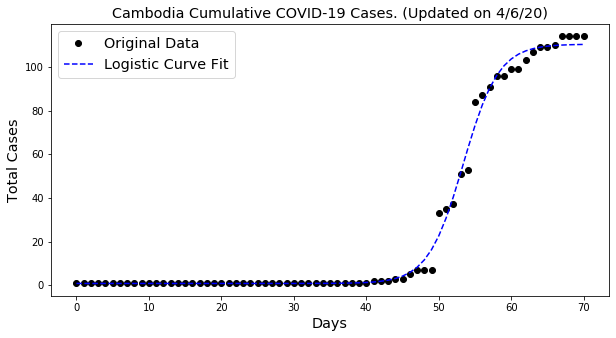



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 113
	Confirmed cases on 3/30/20 	 64
	Ratio: 1.77
	Weekly increase: 76.6 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9918960454681164
	Doubling Time (during middle of growth):  8.96 (± 2.43 ) days
	param:  [ 5.39826077e+01  1.54790735e-01 -2.76533489e+00  1.78808207e+02]

** Based on Exponential Fit **

	R^2: 0.9886637861083941
	Doubling Time (represents overall growth):  8.74 (± 1.3 ) days
	param:  [ 13.09830343   0.07934795 -15.29746337]


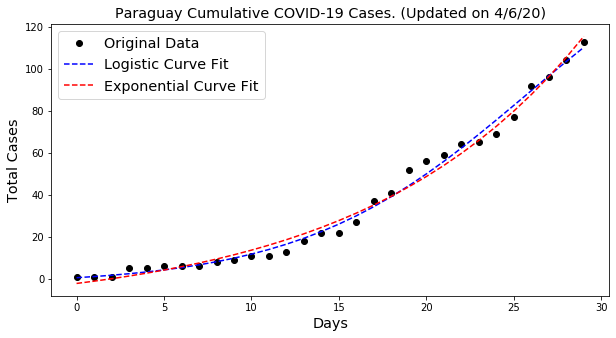



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 105
	Confirmed cases on 3/30/20 	 70
	Ratio: 1.5
	Weekly increase: 50.0 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9921841063601593
	Doubling Time (during middle of growth):  8.02 (± 2.61 ) days
	param:  [ 10.63208042   0.17281025 -13.34712049 128.70868916]

** Based on Exponential Fit **

	R^2: 0.9856286841721884
	Doubling Time (represents overall growth):  20.34 (± 10.18 ) days
	param:  [ 9.71112341e+01  3.40804452e-02 -1.00000000e+02]


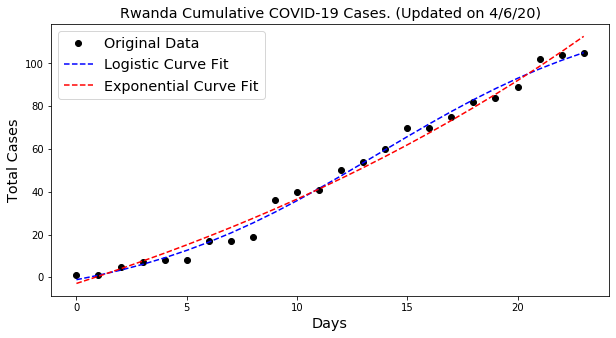



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/6/20 	 105
	Confirmed cases on 3/30/20 	 82
	Ratio: 1.28
	Weekly increase: 28.0 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.6 days

** Based on Logistic Fit**

	R^2: 0.9676975285285561
	Doubling Time (during middle of growth):  7.08 (± 4.12 ) days
	param:  [  5.23220631   0.19586995 -26.6368923  110.65234252]

 exponential R^2  0.9205541944903352


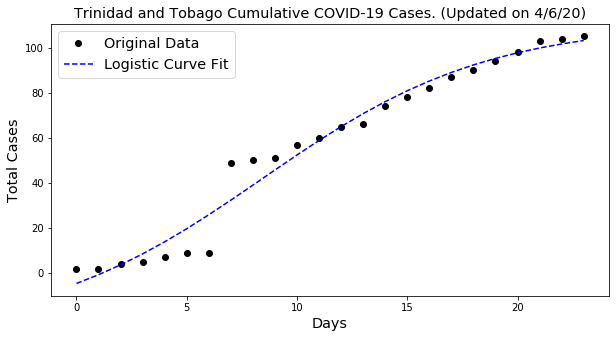

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       6.1    0.2                   5.9
1                       6.6    0.1                  11.0
2                       8.4    0.2                  18.3
3                       7.0    0.2                  11.1
4                       5.7    0.2                   6.2
5                       6.6    0.5                 856.4
6                      17.4    2.7                  12.9
7                       7.0    0.2                   5.7
8                       5.2    0.5                   4.7
9                       6.8    0.4                  15.8
10                      6.6    0.3                   8.7
11                      7.4    0.3                  10.3
12                      6.5    0.3                 

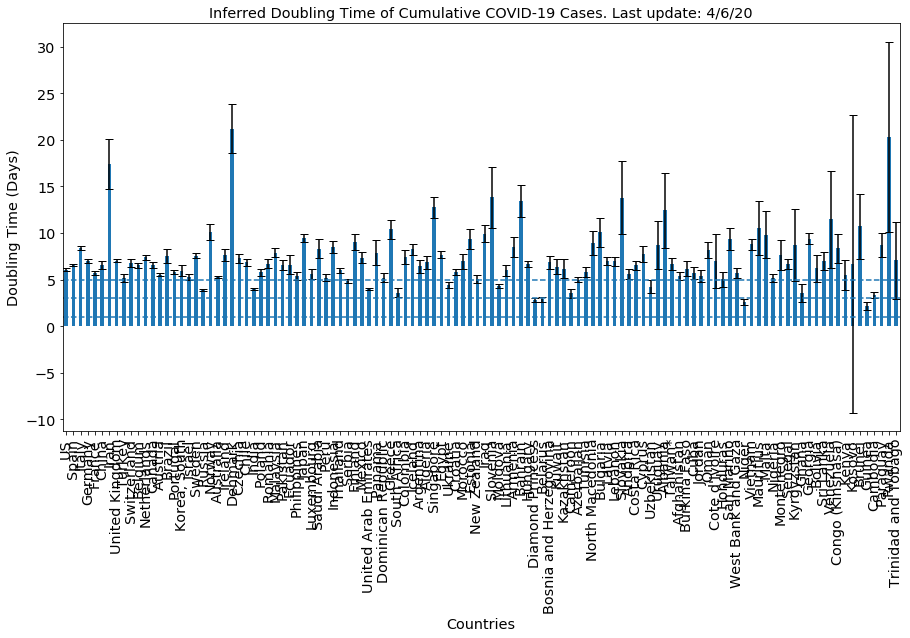

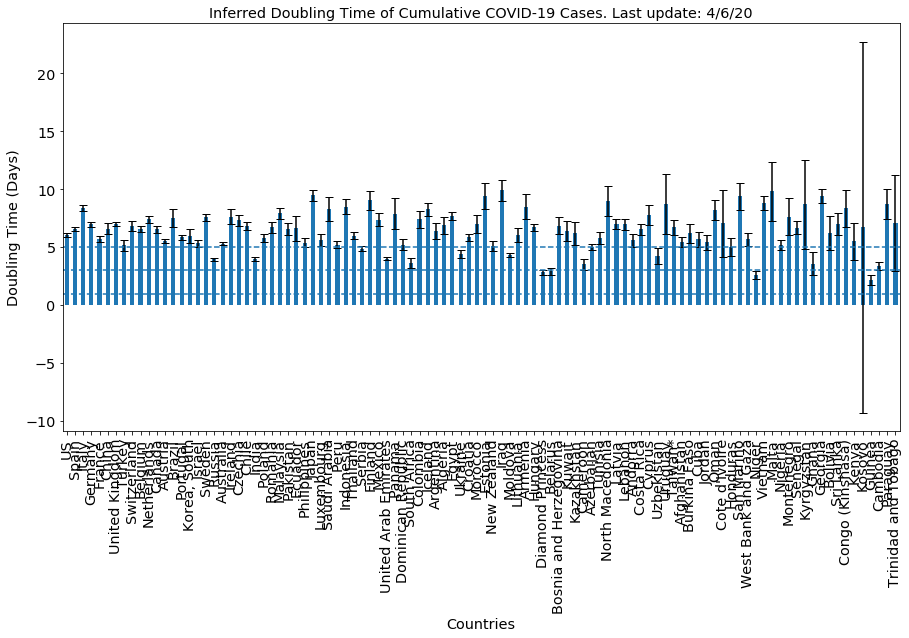

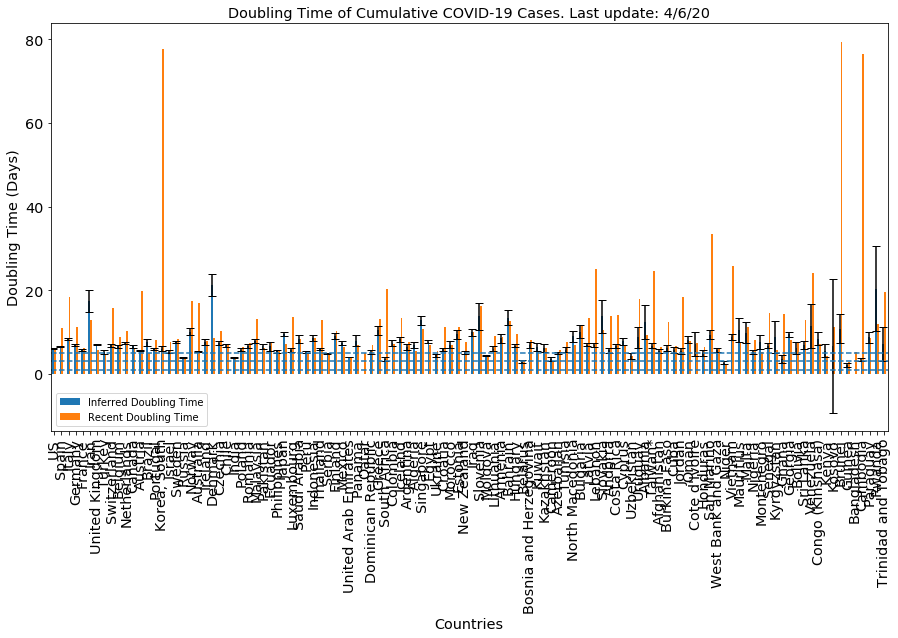

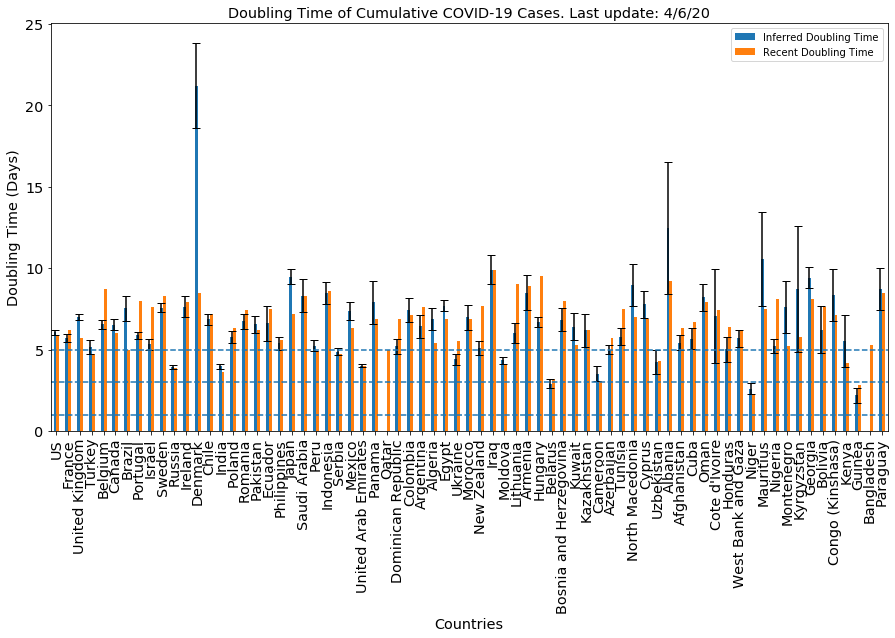

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()